In [1]:
import sys
sys.path.append("..")


import numpy as np
import random
import csv

from idtrees.utils import read_tifs #, load_data # Import data utils
%matplotlib inline 
import matplotlib.pyplot as plt
from configs import *

## Read and Display One Hyperspectral Image

HSI image shape:  (369, 20, 20)


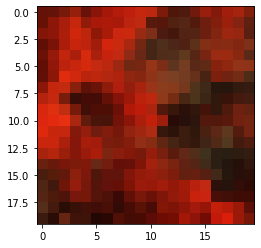

In [2]:
hsi_im_paths = read_tifs.get_im_paths('HSI')
im_id = 29
im = read_tifs.read_tif_to_ndarray(hsi_im_paths[im_id])

print('HSI image shape: ', im.shape)

# Grab a random three band combination
bands = (91,200,360)

# Plot an HSI Image 
im_plt = np.rollaxis(im[bands,:,:],0,start=3)
plt.imshow(im_plt)

## Show first n hyperspectral images 

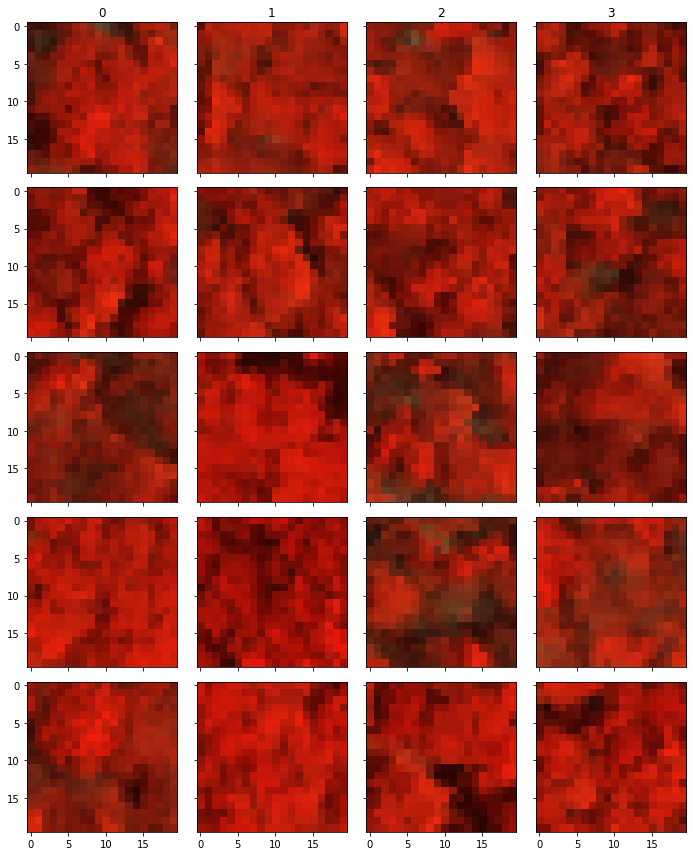

In [3]:
n = 20
ims = read_tifs.read_all_tif_to_ndarray(hsi_im_paths)[:n]
read_tifs.plot_all_ims(ims[:,bands,:,:], title='hsi')

In [4]:
# Read in all HSI images
ims_hsi = read_tifs.read_all_tif_to_ndarray(hsi_im_paths)
print('Total Number of HSI images: ', ims_hsi.shape[0])

Total Number of HSI images:  85


## Plot mean over all hyperspectral pixels in all images

(85, 369, 20, 20)


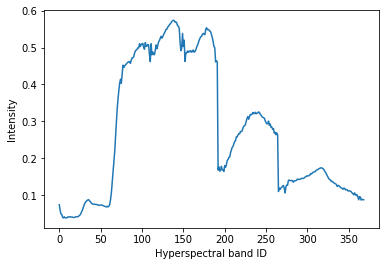

In [5]:
read_tifs.plot_spectral_curve(ims_hsi)

### Extracting ITCs as differently sized HSI images with a Tree Species Label

In [6]:
import torch
from idtrees.utils.dataset import TreeImagesDataset

# Load hsi dataset of bounding boxes with torch dataloader
csv_file ='data/data_train_mitree.csv'
root_dir = repo_path
image_dataset = TreeImagesDataset(csv_file, root_dir, object_rec=False, datatype='hsi', instance_type = 'boxes')
image_dataset = torch.utils.data.Subset(image_dataset, [0]) # TODO: find out what the [0] does

# Get number of bounding boxes in dataset
n_boxes = image_dataset.dataset.__len__()
print('Number of trees, labeled with species and bounding box: ', n_boxes)

Number of trees, labeled with species and bounding box:  1165


In [7]:
im_all = []
class_ids = []
for idx in range(n_boxes): 
    # Get image and target of current bounding box 
    im, target = image_dataset.dataset.__getitem__(idx)
    im_all.append(im)
    class_ids.append(target['labels'])
    
classes = np.unique(class_ids)

print("")
print("Number of HSI bounding boxes images: ", len(im_all))
print("Number of Class ID's: ", len(class_ids))
print("Number of Unique Tree Classes in Data: ", len(classes))


[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box

Number of HSI bounding boxes images:  1165
Number of Class ID's:  1165
Number of Unique Tree Classes in Data:  33


In [8]:
import pandas as pd
df = pd.read_csv(repo_path + 'data/train/Field/taxonID_ScientificName.csv')

class_id_val = []
n_im_val = []
sci_names = []

# Iterate over each class and print class id, number of pixels, and scientific name
print('cls_id \tn_px \tscientific name')
for c in classes:
    ids_in_c = np.where(class_ids == c)[0]
    n_im = len([class_ids[x] for x in ids_in_c])
    sci_name = df[df.taxonCode==c].scientificName.iloc[0]
    class_id_val.append(c)
    n_im_val.append(n_im)
    sci_names.append(sci_name)
    
    print(str(int(c)) +":\t"+ str(n_im) + "\t"+  sci_name)

cls_id 	n_px 	scientific name
1:	8	Acer pensylvanicum L.
2:	139	Acer rubrum L.
3:	1	Acer saccharum Marshall
4:	46	Amelanchier laevis Wiegand
5:	6	Betula sp.
6:	3	Carya glabra (Mill.) Sweet
7:	1	Carya tomentosa (Lam.) Nutt.
8:	6	Fagus grandifolia Ehrh.
9:	1	Gordonia lasianthus (L.) Ellis
10:	17	Liriodendron tulipifera L.
11:	1	Lyonia lucida (Lam.) K. Koch
12:	15	Magnolia sp.
13:	2	Nyssa biflora Walter
14:	45	Nyssa sylvatica Marshall
15:	11	Oxydendrum sp.
16:	2	Persea palustris (Raf.) Sarg.
17:	6	Pinus elliottii Engelm.
18:	367	Pinus palustris Mill.
19:	9	Pinus sp.
20:	4	Pinus taeda L.
21:	7	Prunus serotina Ehrh.
22:	103	Quercus alba L.
23:	53	Quercus coccinea
24:	18	Quercus geminata Small
25:	5	Quercus hemisphaerica W. Bartram ex Willd.
26:	97	Quercus laevis Walter
27:	1	Quercus laurifolia Michx.
28:	12	Quercus montana Willd.
29:	3	Quercus nigra L.
30:	169	Quercus rubra L.
31:	1	Quercus sp.
32:	2	Robinia pseudoacacia L.
33:	4	Tsuga canadensis (L.) Carriere


### We only use the following class_ids
Can't use just the top 4 classes and group everything else into other because you then get a huge class imbalance. Chose ones with over 2000 pixels. 

Use: (2, 18, 22, 23, 26, 30)
Other: All the rest 

In [9]:
keep = np.array([2.,18., 22., 23., 26., 30.])
im_keep = []
im_not_keep = []
new_class_ids = []


for c in keep:
    ids_in_c = np.where(class_ids == c)[0]
    n_im = [im_all[x] for x in ids_in_c]
    for n in n_im:
        im_keep.append(n)
        new_class_ids.append(c)

for c in classes:
    if c not in keep:
        ids_nin_c = np.where(class_ids == c)[0] 
        n_im = [im_all[x] for x in ids_nin_c]
        for n in n_im:
            im_not_keep.append(n)
            new_class_ids.append(34.)

print(len(im_not_keep), len(im_keep))

#combine into new total list, with a 34th class id known as 'Other'
im_all_new = im_keep 
im_all_new.extend(im_not_keep)

new_classes = np.unique(new_class_ids)
print(new_classes)


237 928
[ 2. 18. 22. 23. 26. 30. 34.]


In [10]:
print(len(new_class_ids))
print(len(im_all_new))

1165
1165


In [11]:
df.loc[34, :] = [34., 'OTHER', 'ALL Others']

class_id_val = []
n_im_val = []
sci_names = []

# Iterate over each class and print class id, number of pixels, and scientific name
print('cls_id \tn_px \tscientific name')

for c in new_classes:
    ids_in_c = np.where(new_class_ids == c)[0]
    n_im = len([new_class_ids[x] for x in ids_in_c])
    sci_name = df[df.taxonCode==c].scientificName.iloc[0]
    class_id_val.append(c)
    n_im_val.append(n_im)
    sci_names.append(sci_name)
    
    print(str(int(c)) +":\t"+ str(n_im) + "\t"+  sci_name)
    

cls_id 	n_px 	scientific name
2:	139	Acer rubrum L.
18:	367	Pinus palustris Mill.
22:	103	Quercus alba L.
23:	53	Quercus coccinea
26:	97	Quercus laevis Walter
30:	169	Quercus rubra L.
34:	237	ALL Others


In [12]:
data = read_tifs.get_hsi_pixels()


Number of trees, labeled with species and bounding box:  1165
tensor([[[0.0350, 0.0406, 0.0360, 0.0312],
         [0.0266, 0.0312, 0.0386, 0.0270],
         [0.0347, 0.0367, 0.0400, 0.0331],
         [0.0344, 0.0339, 0.0321, 0.0258]],

        [[0.0460, 0.0405, 0.0414, 0.0326],
         [0.0483, 0.0462, 0.0518, 0.0288],
         [0.0439, 0.0492, 0.0495, 0.0418],
         [0.0464, 0.0454, 0.0495, 0.0405]],

        [[0.0477, 0.0419, 0.0390, 0.0345],
         [0.0480, 0.0510, 0.0469, 0.0352],
         [0.0472, 0.0426, 0.0452, 0.0393],
         [0.0452, 0.0492, 0.0429, 0.0365]],

        ...,

        [[0.0464, 0.0437, 0.0354, 0.0166],
         [0.0454, 0.0383, 0.0423, 0.0204],
         [0.0585, 0.0536, 0.0465, 0.0345],
         [0.0469, 0.0474, 0.0436, 0.0358]],

        [[0.0479, 0.0347, 0.0316, 0.0189],
         [0.0487, 0.0360, 0.0508, 0.0212],
         [0.0618, 0.0319, 0.0577, 0.0225],
         [0.0416, 0.0525, 0.0556, 0.0436]],

        [[0.0326, 0.0383, 0.0247, 0.0186],
         [0

tensor([[[0.0312, 0.0353, 0.0304, 0.0370, 0.0386, 0.0419],
         [0.0338, 0.0347, 0.0353, 0.0399, 0.0371, 0.0395],
         [0.0340, 0.0328, 0.0341, 0.0362, 0.0395, 0.0392],
         [0.0361, 0.0374, 0.0340, 0.0370, 0.0364, 0.0388]],

        [[0.0394, 0.0426, 0.0458, 0.0435, 0.0489, 0.0492],
         [0.0420, 0.0434, 0.0438, 0.0461, 0.0453, 0.0505],
         [0.0456, 0.0422, 0.0492, 0.0481, 0.0495, 0.0520],
         [0.0456, 0.0420, 0.0490, 0.0499, 0.0444, 0.0471]],

        [[0.0389, 0.0440, 0.0425, 0.0407, 0.0498, 0.0477],
         [0.0355, 0.0444, 0.0474, 0.0462, 0.0464, 0.0434],
         [0.0386, 0.0453, 0.0455, 0.0471, 0.0464, 0.0483],
         [0.0437, 0.0425, 0.0423, 0.0477, 0.0440, 0.0434]],

        ...,

        [[0.0408, 0.0382, 0.0343, 0.0361, 0.0465, 0.0370],
         [0.0352, 0.0456, 0.0371, 0.0423, 0.0650, 0.0410],
         [0.0554, 0.0563, 0.0562, 0.0538, 0.0522, 0.0447],
         [0.0478, 0.0486, 0.0581, 0.0547, 0.0422, 0.0472]],

        [[0.0335, 0.0361, 0.0431, 

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0458, 0.0408, 0.0546, 0.0518],
         [0.0503, 0.0446, 0.0585, 0.0558],
         [0.0436, 0.0491, 0.0488, 0.0577],
         [0.0432, 0.0498, 0.0572, 0.0494]],

        [[0.0499, 0.0394, 0.0512, 0.0450],
         [0.0428, 0.0434, 0.0551, 0.0602],
         [0.0462, 0.0450, 0.0477, 0.0491],
         [0.0421, 0.0475, 0.0491, 0.0468]],

        ...,

        [[0.0621, 0.0657, 0.0851, 0.0791],
         [0.0607, 0.0536, 0.0889, 0.1114],
         [0.0469, 0.0490, 0.0892, 0.1044],
         [0.0305, 0.0494, 0.0543, 0.0886]],

        [[0.0744, 0.0710, 0.0845, 0.0699],
         [0.0737, 0.0566, 0.0822, 0.1187],
         [0.0482, 0.0458, 0.0893, 0.0936],
         [0.0297, 0.0424, 0.0629, 0.0960]],

        [[0.0580, 0.0684, 0.0832, 0.0781],
         [0.0631, 0.0659, 0.0895, 0.1150],
         [0.0425, 0.0587, 0.08

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0428, 0.0339, 0.0441, 0.0404, 0.0362, 0.0318],
         [0.0357, 0.0411, 0.0445, 0.0386, 0.0444, 0.0389],
         [0.0348, 0.0373, 0.0397, 0.0347, 0.0320, 0.0365]],

        [[0.0375, 0.0437, 0.0430, 0.0348, 0.0316, 0.0350],
         [0.0350, 0.0391, 0.0393, 0.0353, 0.0370, 0.0327],
         [0.0393, 0.0443, 0.0426, 0.0311, 0.0311, 0.0418]],

        ...,

        [[0.0358, 0.0472, 0.0486, 0.0328, 0.0246, 0.0294],
         [0.0290, 0.0418, 0.0431, 0.0294, 0.0298, 0.0248],
         [0.0161, 0.0344, 0.0312, 0.0279, 0.0242, 0.0292]],

        [[0.0333, 0.0399, 0.0609, 0.0377, 0.0337, 0.0227],
         [0.0387, 0.0453, 0.0365, 0.0262, 0.0329, 0.0245],
         [0.0285, 0.0411, 0.0391, 0.0411, 0.0354, 0.0315]],

        [[0.0383, 0.0406, 0.0494, 0.0391, 0.0279, 0.0269],
         [0.0324, 0.0464, 0.0410

tensor([[[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0393, 0.0412, 0.0542],
         [0.0406, 0.0549, 0.0575],
         [0.0538, 0.0398, 0.0454]],

        [[0.0455, 0.0505, 0.0455],
         [0.0486, 0.0497, 0.0525],
         [0.0491, 0.0417, 0.0364]],

        ...,

        [[0.0504, 0.0421, 0.0469],
         [0.0471, 0.0496, 0.0578],
         [0.0381, 0.0535, 0.0379]],

        [[0.0499, 0.0482, 0.0417],
         [0.0449, 0.0664, 0.0608],
         [0.0385, 0.0504, 0.0410]],

        [[0.0347, 0.0424, 0.0466],
         [0.0448, 0.0359, 0.0713],
         [0.0354, 0.0446, 0.0407]]]) {'labels': 2.0, 'uid': 'MLBS00419'}
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],

tensor([[[0.0372, 0.0377, 0.0314, 0.0312, 0.0234, 0.0234],
         [0.0421, 0.0326, 0.0406, 0.0306, 0.0294, 0.0294],
         [0.0370, 0.0350, 0.0406, 0.0360, 0.0312, 0.0291]],

        [[0.0567, 0.0500, 0.0418, 0.0416, 0.0383, 0.0383],
         [0.0531, 0.0367, 0.0405, 0.0363, 0.0303, 0.0303],
         [0.0523, 0.0460, 0.0405, 0.0414, 0.0326, 0.0299]],

        [[0.0533, 0.0446, 0.0393, 0.0391, 0.0308, 0.0308],
         [0.0419, 0.0462, 0.0419, 0.0375, 0.0303, 0.0303],
         [0.0511, 0.0477, 0.0419, 0.0390, 0.0345, 0.0362]],

        ...,

        [[0.0477, 0.0571, 0.0390, 0.0388, 0.0240, 0.0240],
         [0.0335, 0.0419, 0.0439, 0.0382, 0.0206, 0.0206],
         [0.0497, 0.0464, 0.0437, 0.0354, 0.0166, 0.0158]],

        [[0.0452, 0.0618, 0.0322, 0.0321, 0.0373, 0.0373],
         [0.0401, 0.0513, 0.0347, 0.0403, 0.0158, 0.0158],
         [0.0490, 0.0479, 0.0347, 0.0316, 0.0189, 0.0186]],

        [[0.0457, 0.0580, 0.0405, 0.0403, 0.0248, 0.0248],
         [0.0470, 0.0401, 0.0383

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0495, 0.0468, 0.0443, 0.0455],
         [0.0479, 0.0422, 0.0456, 0.0382],
         [0.0487, 0.0414, 0.0419, 0.0461],
         [0.0411, 0.0386, 0.0435, 0.0420],
         [0.0392, 0.0352, 0.0417, 0.0431]],

        [[0.0429, 0.0473, 0.0416, 0.0376],
         [0.0487, 0.0449, 0.0382, 0.0388],
         [0.0423, 0.0410, 0.0398, 0.0438],
         [0.0461, 0.0386, 0.0356, 0.0452],
         [0.0435, 0.0338, 0.0332, 0.0370]],

        ...,

        [[0.0578, 0.0565, 0.0453, 0.0286],
         [0.0546, 0.0435, 0.0405, 0.0352],
         [0.0540, 0.0310, 0.0319, 0.0361],
         [0.0435, 0.0277, 0.0240, 0.0410],
         [0.0267, 0.0280, 0.0227, 0.0167]],

        [[0.0637, 0.0587, 0.0523, 0.0423],
         [0.0665, 0.0419, 0.0288, 0.0310],
         [0.0450, 0.0285, 0.0322

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0417, 0.0496, 0.0529,  ..., 0.0549, 0.0479, 0.0335],
         [0.0449, 0.0480, 0.0497,  ..., 0.0405, 0.0438, 0.0438],
         [0.0436, 0.0395, 0.0430,  ..., 0.0444, 0.0417, 0.0379],
         [0.0425, 0.0425, 0.0507,  ..., 0.0395, 0.0420, 0.0405],
         [0.0466, 0.0479, 0.0505,  ..., 0.0449, 0.0346, 0.0422]],

        [[0.0464, 0.0378, 0.0453,  ..., 0.0479, 0.0452, 0.0321],
         [0.0477, 0.0403, 0.0417,  ..., 0.0486, 0.0467, 0.0381],
         [0.0356, 0.0409, 0.0512,  ..., 0.0438, 0.0444, 0.0362],
         [0.0433, 0.0382, 0.0496,  ..., 0.0305, 0.0449, 0.0360],
         [0.0403, 0.0438, 0.0548,  ..., 0.0359, 0.0305, 0.0340]],

        ...,

     

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0374, 0.0402, 0.0358, 0.0318, 0.0374],
         [0.0292, 0.0414, 0.0328, 0.0327, 0.0370],
         [0.0374, 0.0345, 0.0340, 0.0369, 0.0433],
         [0.0337, 0.0289, 0.0403, 0.0453, 0.0446],
         [0.0340, 0.0428, 0.0421, 0.0462, 0.0437]],

        [[0.0364, 0.0305, 0.0283, 0.0373, 0.0335],
         [0.0286, 0.0370, 0.0292, 0.0356, 0.0433],
         [0.0327, 0.0351, 0.0345, 0.0377, 0.0383],
         [0.0332, 0.0329, 0.0350, 0.0334, 0.0392],
         [0.0311, 0.0313, 0.0308, 0.0383, 0.0386]],

        ...,

        [[0.0225, 0.0213, 0.0131, 0.0184, 0.0257],
         [0.0190, 0.0148, 0.0215, 0.0145, 0.0213],
         [0.0154, 0.0158, 0.0154, 0.0190, 0.0290],
         [0.0081, 0.0142, 0.0160, 0.0163, 0.0189],
         [0

tensor([[[0.0278, 0.0304, 0.0307,  ..., 0.0268, 0.0251, 0.0355],
         [0.0289, 0.0262, 0.0362,  ..., 0.0314, 0.0307, 0.0294],
         [0.0259, 0.0307, 0.0366,  ..., 0.0331, 0.0333, 0.0294],
         ...,
         [0.0297, 0.0313, 0.0333,  ..., 0.0373, 0.0320, 0.0344],
         [0.0256, 0.0356, 0.0406,  ..., 0.0265, 0.0397, 0.0376],
         [0.0296, 0.0300, 0.0249,  ..., 0.0316, 0.0349, 0.0335]],

        [[0.0392, 0.0444, 0.0418,  ..., 0.0349, 0.0338, 0.0362],
         [0.0287, 0.0392, 0.0383,  ..., 0.0417, 0.0438, 0.0379],
         [0.0356, 0.0369, 0.0387,  ..., 0.0438, 0.0397, 0.0378],
         ...,
         [0.0344, 0.0413, 0.0428,  ..., 0.0399, 0.0395, 0.0409],
         [0.0399, 0.0354, 0.0406,  ..., 0.0390, 0.0409, 0.0433],
         [0.0396, 0.0411, 0.0402,  ..., 0.0379, 0.0390, 0.0431]],

        [[0.0297, 0.0390, 0.0431,  ..., 0.0345, 0.0348, 0.0399],
         [0.0299, 0.0372, 0.0423,  ..., 0.0396, 0.0414, 0.0347],
         [0.0311, 0.0307, 0.0407,  ..., 0.0386, 0.0426, 0.

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0424, 0.0478, 0.0493, 0.0467, 0.0465],
         [0.0416, 0.0475, 0.0485, 0.0448, 0.0434],
         [0.0515, 0.0435, 0.0494, 0.0424, 0.0430],
         [0.0443, 0.0411, 0.0437, 0.0416, 0.0435],
         [0.0456, 0.0371, 0.0418, 0.0430, 0.0432]],

        [[0.0432, 0.0399, 0.0391, 0.0405, 0.0375],
         [0.0435, 0.0448, 0.0464, 0.0373, 0.0392],
         [0.0413, 0.0418, 0.0462, 0.0355, 0.0432],
         [0.0395, 0.0389, 0.0357, 0.0392, 0.0477],
         [0.0440, 0.0349, 0.0351, 0.0378, 0.0379]],

        ...,

        [[0.0354, 0.0325, 0.0295, 0.0301, 0.0204],
         [0.0371, 0.0320, 0.0357, 0.0253, 0.0180],
         [0.0402, 0.0357, 0.0252, 0.0279, 0.0253],
         [0.0357, 0.0392, 0.0132, 0.0257, 0.0234],
         [0

tensor([[[0.0242, 0.0278, 0.0241, 0.0280, 0.0314, 0.0260],
         [0.0280, 0.0193, 0.0262, 0.0348, 0.0302, 0.0296],
         [0.0309, 0.0345, 0.0332, 0.0294, 0.0260, 0.0314],
         [0.0254, 0.0278, 0.0277, 0.0242, 0.0280, 0.0311],
         [0.0236, 0.0262, 0.0272, 0.0274, 0.0268, 0.0239]],

        [[0.0376, 0.0311, 0.0378, 0.0419, 0.0357, 0.0446],
         [0.0378, 0.0412, 0.0348, 0.0449, 0.0342, 0.0266],
         [0.0397, 0.0467, 0.0428, 0.0500, 0.0437, 0.0378],
         [0.0250, 0.0446, 0.0406, 0.0400, 0.0461, 0.0403],
         [0.0251, 0.0263, 0.0333, 0.0459, 0.0403, 0.0406]],

        [[0.0323, 0.0251, 0.0338, 0.0378, 0.0332, 0.0314],
         [0.0323, 0.0293, 0.0369, 0.0387, 0.0332, 0.0390],
         [0.0391, 0.0396, 0.0364, 0.0400, 0.0335, 0.0341],
         [0.0336, 0.0403, 0.0422, 0.0363, 0.0320, 0.0305],
         [0.0241, 0.0303, 0.0379, 0.0406, 0.0323, 0.0396]],

        ...,

        [[0.0468, 0.0202, 0.0320, 0.0358, 0.0263, 0.0401],
         [0.0363, 0.0241, 0.0226, 0.

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0353, 0.0270, 0.0349,  ..., 0.0415, 0.0399, 0.0365],
         [0.0404, 0.0356, 0.0362,  ..., 0.0375, 0.0407, 0.0373],
         [0.0364, 0.0351, 0.0320,  ..., 0.0422, 0.0250, 0.0410],
         [0.0340, 0.0351, 0.0356,  ..., 0.0367, 0.0380, 0.0391],
         [0.0420, 0.0393, 0.0435,  ..., 0.0459, 0.0373, 0.0378],
         [0.0417, 0.0377, 0.0439,  ..., 0.0410, 0.0425, 0.0380]],

        [[0.0383, 0.0386, 0.0351,  ..., 0.0365, 0.0307, 0.0319],
         [0.0320, 0.0365, 0.0361,  ..., 0.0362, 0.0383, 0.0356],
         [0.0365, 0.0361, 0.0357,  ..., 0.0370, 0.0312, 0.0404],
         [0.0346, 0.0

tensor([[[0.0371, 0.0361, 0.0397],
         [0.0385, 0.0412, 0.0341],
         [0.0347, 0.0392, 0.0374]],

        [[0.0476, 0.0442, 0.0440],
         [0.0470, 0.0436, 0.0430],
         [0.0432, 0.0463, 0.0420]],

        [[0.0461, 0.0402, 0.0404],
         [0.0439, 0.0423, 0.0457],
         [0.0416, 0.0488, 0.0406]],

        ...,

        [[0.0738, 0.0650, 0.0505],
         [0.0670, 0.0487, 0.0593],
         [0.0464, 0.0460, 0.0632]],

        [[0.0789, 0.0669, 0.0546],
         [0.0715, 0.0546, 0.0580],
         [0.0519, 0.0543, 0.0577]],

        [[0.0766, 0.0659, 0.0608],
         [0.0624, 0.0552, 0.0540],
         [0.0435, 0.0595, 0.0584]]]) {'labels': 4.0, 'uid': 'MLBS00155'}
tensor([[[0.0463, 0.0425, 0.0412,  ..., 0.0407, 0.0376, 0.0369],
         [0.0418, 0.0459, 0.0375,  ..., 0.0334, 0.0351, 0.0369],
         [0.0404, 0.0384, 0.0393,  ..., 0.0383, 0.0364, 0.0328],
         [0.0415, 0.0389, 0.0330,  ..., 0.0373, 0.0358, 0.0415]],

        [[0.0600, 0.0544, 0.0557,  ..., 0.0485

tensor([[[0.0308, 0.0269, 0.0280],
         [0.0267, 0.0240, 0.0326],
         [0.0319, 0.0299, 0.0361],
         ...,
         [0.0310, 0.0302, 0.0318],
         [0.0333, 0.0282, 0.0351],
         [0.0352, 0.0302, 0.0332]],

        [[0.0404, 0.0390, 0.0494],
         [0.0410, 0.0332, 0.0390],
         [0.0424, 0.0408, 0.0431],
         ...,
         [0.0374, 0.0333, 0.0368],
         [0.0444, 0.0341, 0.0417],
         [0.0425, 0.0473, 0.0434]],

        [[0.0408, 0.0349, 0.0329],
         [0.0434, 0.0335, 0.0381],
         [0.0361, 0.0402, 0.0371],
         ...,
         [0.0402, 0.0365, 0.0342],
         [0.0423, 0.0410, 0.0408],
         [0.0398, 0.0407, 0.0392]],

        ...,

        [[0.0348, 0.0231, 0.0365],
         [0.0285, 0.0220, 0.0310],
         [0.0356, 0.0371, 0.0341],
         ...,
         [0.0319, 0.0322, 0.0318],
         [0.0497, 0.0328, 0.0392],
         [0.0493, 0.0434, 0.0398]],

        [[0.0276, 0.0418, 0.0287],
         [0.0336, 0.0285, 0.0362],
         [0.

tensor([[[0.0298, 0.0428, 0.0321, 0.0367, 0.0367, 0.0279],
         [0.0335, 0.0354, 0.0422, 0.0394, 0.0400, 0.0268],
         [0.0335, 0.0316, 0.0386, 0.0389, 0.0389, 0.0305],
         [0.0340, 0.0298, 0.0366, 0.0389, 0.0278, 0.0386],
         [0.0309, 0.0324, 0.0406, 0.0374, 0.0254, 0.0305]],

        [[0.0347, 0.0374, 0.0532, 0.0443, 0.0443, 0.0490],
         [0.0485, 0.0535, 0.0529, 0.0468, 0.0561, 0.0369],
         [0.0454, 0.0461, 0.0532, 0.0530, 0.0530, 0.0381],
         [0.0381, 0.0453, 0.0538, 0.0484, 0.0425, 0.0385],
         [0.0315, 0.0397, 0.0498, 0.0526, 0.0473, 0.0377]],

        [[0.0405, 0.0394, 0.0490, 0.0391, 0.0391, 0.0411],
         [0.0459, 0.0461, 0.0499, 0.0499, 0.0408, 0.0354],
         [0.0402, 0.0392, 0.0456, 0.0495, 0.0495, 0.0481],
         [0.0358, 0.0397, 0.0471, 0.0482, 0.0419, 0.0485],
         [0.0400, 0.0355, 0.0428, 0.0431, 0.0361, 0.0456]],

        ...,

        [[0.0470, 0.0433, 0.0450, 0.0386, 0.0386, 0.0419],
         [0.0411, 0.0400, 0.0431, 0.

tensor([[[0.0334, 0.0306, 0.0296],
         [0.0296, 0.0328, 0.0371],
         [0.0343, 0.0334, 0.0321],
         ...,
         [0.0303, 0.0304, 0.0335],
         [0.0320, 0.0326, 0.0290],
         [0.0382, 0.0314, 0.0413]],

        [[0.0410, 0.0384, 0.0422],
         [0.0396, 0.0384, 0.0408],
         [0.0470, 0.0427, 0.0490],
         ...,
         [0.0418, 0.0391, 0.0338],
         [0.0436, 0.0357, 0.0337],
         [0.0461, 0.0418, 0.0426]],

        [[0.0396, 0.0399, 0.0384],
         [0.0420, 0.0436, 0.0355],
         [0.0423, 0.0452, 0.0420],
         ...,
         [0.0345, 0.0327, 0.0374],
         [0.0386, 0.0364, 0.0391],
         [0.0385, 0.0310, 0.0369]],

        ...,

        [[0.0358, 0.0282, 0.0388],
         [0.0374, 0.0360, 0.0378],
         [0.0391, 0.0483, 0.0393],
         ...,
         [0.0437, 0.0372, 0.0386],
         [0.0443, 0.0360, 0.0360],
         [0.0436, 0.0422, 0.0412]],

        [[0.0396, 0.0419, 0.0365],
         [0.0384, 0.0347, 0.0426],
         [0.

tensor([[[0.0244, 0.0233, 0.0342, 0.0286],
         [0.0283, 0.0314, 0.0294, 0.0272],
         [0.0354, 0.0281, 0.0268, 0.0281],
         [0.0303, 0.0312, 0.0257, 0.0306]],

        [[0.0416, 0.0418, 0.0399, 0.0323],
         [0.0404, 0.0445, 0.0336, 0.0306],
         [0.0477, 0.0341, 0.0434, 0.0357],
         [0.0433, 0.0454, 0.0464, 0.0357]],

        [[0.0321, 0.0364, 0.0327, 0.0369],
         [0.0355, 0.0341, 0.0226, 0.0324],
         [0.0486, 0.0370, 0.0287, 0.0352],
         [0.0494, 0.0378, 0.0352, 0.0330]],

        ...,

        [[0.0335, 0.0291, 0.0314, 0.0299],
         [0.0418, 0.0379, 0.0244, 0.0308],
         [0.0852, 0.0567, 0.0476, 0.0343],
         [0.0993, 0.0562, 0.0492, 0.0308]],

        [[0.0375, 0.0471, 0.0216, 0.0253],
         [0.0400, 0.0485, 0.0250, 0.0247],
         [0.0787, 0.0743, 0.0382, 0.0321],
         [0.1011, 0.0525, 0.0448, 0.0326]],

        [[0.0226, 0.0416, 0.0352, 0.0251],
         [0.0354, 0.0473, 0.0286, 0.0266],
         [0.0828, 0.0581, 0.04

tensor([[[0.0346, 0.0348, 0.0337, 0.0364, 0.0423, 0.0360],
         [0.0342, 0.0363, 0.0351, 0.0379, 0.0412, 0.0391],
         [0.0330, 0.0340, 0.0360, 0.0337, 0.0402, 0.0409],
         ...,
         [0.0312, 0.0319, 0.0344, 0.0337, 0.0397, 0.0359],
         [0.0364, 0.0289, 0.0363, 0.0351, 0.0446, 0.0352],
         [0.0408, 0.0375, 0.0433, 0.0330, 0.0432, 0.0360]],

        [[0.0457, 0.0414, 0.0471, 0.0520, 0.0486, 0.0549],
         [0.0454, 0.0454, 0.0476, 0.0514, 0.0489, 0.0451],
         [0.0486, 0.0507, 0.0452, 0.0481, 0.0530, 0.0476],
         ...,
         [0.0442, 0.0385, 0.0489, 0.0474, 0.0526, 0.0527],
         [0.0473, 0.0485, 0.0454, 0.0538, 0.0557, 0.0552],
         [0.0481, 0.0408, 0.0459, 0.0427, 0.0531, 0.0455]],

        [[0.0435, 0.0465, 0.0424, 0.0447, 0.0492, 0.0470],
         [0.0440, 0.0436, 0.0436, 0.0471, 0.0493, 0.0412],
         [0.0390, 0.0418, 0.0428, 0.0503, 0.0496, 0.0463],
         ...,
         [0.0413, 0.0383, 0.0435, 0.0474, 0.0546, 0.0499],
         [

tensor([[[0.0359, 0.0344, 0.0357, 0.0346, 0.0284],
         [0.0323, 0.0360, 0.0349, 0.0391, 0.0345],
         [0.0300, 0.0318, 0.0351, 0.0386, 0.0402],
         [0.0365, 0.0308, 0.0303, 0.0332, 0.0371],
         [0.0281, 0.0326, 0.0283, 0.0319, 0.0363]],

        [[0.0408, 0.0378, 0.0425, 0.0390, 0.0480],
         [0.0462, 0.0437, 0.0374, 0.0429, 0.0466],
         [0.0402, 0.0405, 0.0420, 0.0443, 0.0395],
         [0.0398, 0.0382, 0.0444, 0.0455, 0.0420],
         [0.0416, 0.0398, 0.0440, 0.0389, 0.0484]],

        [[0.0395, 0.0357, 0.0406, 0.0405, 0.0394],
         [0.0351, 0.0435, 0.0387, 0.0404, 0.0401],
         [0.0351, 0.0409, 0.0399, 0.0380, 0.0427],
         [0.0370, 0.0408, 0.0401, 0.0413, 0.0390],
         [0.0353, 0.0370, 0.0398, 0.0397, 0.0376]],

        ...,

        [[0.0221, 0.0232, 0.0162, 0.0236, 0.0128],
         [0.0231, 0.0219, 0.0220, 0.0152, 0.0156],
         [0.0139, 0.0181, 0.0213, 0.0102, 0.0086],
         [0.0242, 0.0166, 0.0155, 0.0147, 0.0103],
         [0

tensor([[[0.0306, 0.0312, 0.0343,  ..., 0.0384, 0.0344, 0.0353],
         [0.0303, 0.0327, 0.0346,  ..., 0.0327, 0.0350, 0.0350],
         [0.0304, 0.0355, 0.0338,  ..., 0.0392, 0.0352, 0.0363],
         [0.0380, 0.0381, 0.0361,  ..., 0.0403, 0.0363, 0.0373],
         [0.0387, 0.0361, 0.0380,  ..., 0.0413, 0.0329, 0.0340]],

        [[0.0378, 0.0522, 0.0472,  ..., 0.0493, 0.0472, 0.0446],
         [0.0458, 0.0466, 0.0416,  ..., 0.0439, 0.0467, 0.0466],
         [0.0423, 0.0472, 0.0479,  ..., 0.0501, 0.0529, 0.0493],
         [0.0556, 0.0561, 0.0464,  ..., 0.0463, 0.0489, 0.0541],
         [0.0526, 0.0561, 0.0498,  ..., 0.0464, 0.0486, 0.0487]],

        [[0.0401, 0.0395, 0.0444,  ..., 0.0478, 0.0393, 0.0409],
         [0.0389, 0.0372, 0.0392,  ..., 0.0429, 0.0409, 0.0396],
         [0.0333, 0.0421, 0.0412,  ..., 0.0456, 0.0427, 0.0490],
         [0.0456, 0.0459, 0.0482,  ..., 0.0492, 0.0452, 0.0478],
         [0.0478, 0.0470, 0.0453,  ..., 0.0470, 0.0404, 0.0541]],

        ...,

     

tensor([[[0.0418, 0.0406, 0.0320, 0.0000],
         [0.0419, 0.0412, 0.0372, 0.0261],
         [0.0361, 0.0352, 0.0266, 0.0313],
         [0.0375, 0.0363, 0.0264, 0.0324]],

        [[0.0552, 0.0541, 0.0389, 0.0363],
         [0.0470, 0.0572, 0.0409, 0.0383],
         [0.0470, 0.0466, 0.0450, 0.0453],
         [0.0489, 0.0492, 0.0450, 0.0429]],

        [[0.0533, 0.0524, 0.0349, 0.0344],
         [0.0489, 0.0469, 0.0450, 0.0370],
         [0.0526, 0.0423, 0.0376, 0.0358],
         [0.0439, 0.0344, 0.0329, 0.0349]],

        ...,

        [[0.0490, 0.0519, 0.0200, 0.0143],
         [0.0478, 0.0553, 0.0301, 0.0320],
         [0.0507, 0.0378, 0.0346, 0.0369],
         [0.0486, 0.0263, 0.0112, 0.0187]],

        [[0.0518, 0.0490, 0.0261, 0.0141],
         [0.0502, 0.0464, 0.0297, 0.0369],
         [0.0430, 0.0358, 0.0186, 0.0247],
         [0.0361, 0.0380, 0.0307, 0.0346]],

        [[0.0558, 0.0415, 0.0304, 0.0128],
         [0.0569, 0.0469, 0.0380, 0.0180],
         [0.0506, 0.0418, 0.03

tensor([[[0.0360, 0.0398, 0.0398, 0.0387, 0.0366, 0.0397],
         [0.0360, 0.0371, 0.0320, 0.0379, 0.0387, 0.0379],
         [0.0341, 0.0398, 0.0397, 0.0386, 0.0384, 0.0346],
         ...,
         [0.0320, 0.0355, 0.0355, 0.0374, 0.0352, 0.0374],
         [0.0292, 0.0355, 0.0344, 0.0394, 0.0402, 0.0373],
         [0.0336, 0.0349, 0.0389, 0.0336, 0.0335, 0.0376]],

        [[0.0430, 0.0456, 0.0456, 0.0465, 0.0496, 0.0465],
         [0.0440, 0.0411, 0.0429, 0.0457, 0.0435, 0.0417],
         [0.0451, 0.0429, 0.0523, 0.0414, 0.0504, 0.0424],
         ...,
         [0.0402, 0.0414, 0.0414, 0.0414, 0.0400, 0.0413],
         [0.0421, 0.0349, 0.0403, 0.0460, 0.0480, 0.0440],
         [0.0445, 0.0446, 0.0427, 0.0484, 0.0483, 0.0483]],

        [[0.0405, 0.0432, 0.0432, 0.0480, 0.0440, 0.0446],
         [0.0443, 0.0421, 0.0403, 0.0441, 0.0449, 0.0381],
         [0.0462, 0.0457, 0.0408, 0.0432, 0.0416, 0.0386],
         ...,
         [0.0413, 0.0413, 0.0413, 0.0430, 0.0475, 0.0413],
         [

tensor([[[0.0411, 0.0340, 0.0392],
         [0.0432, 0.0392, 0.0371],
         [0.0385, 0.0363, 0.0418]],

        [[0.0461, 0.0423, 0.0456],
         [0.0409, 0.0475, 0.0406],
         [0.0373, 0.0394, 0.0420]],

        [[0.0437, 0.0451, 0.0421],
         [0.0402, 0.0434, 0.0416],
         [0.0459, 0.0427, 0.0409]],

        ...,

        [[0.0382, 0.0363, 0.0351],
         [0.0342, 0.0404, 0.0307],
         [0.0394, 0.0345, 0.0214]],

        [[0.0454, 0.0437, 0.0399],
         [0.0442, 0.0430, 0.0347],
         [0.0366, 0.0363, 0.0356]],

        [[0.0472, 0.0359, 0.0451],
         [0.0404, 0.0485, 0.0423],
         [0.0282, 0.0330, 0.0377]]]) {'labels': 14.0, 'uid': 'MLBS00328'}
tensor([[[0.0387],
         [0.0382],
         [0.0339],
         [0.0325]],

        [[0.0463],
         [0.0459],
         [0.0458],
         [0.0439]],

        [[0.0453],
         [0.0413],
         [0.0404],
         [0.0361]],

        ...,

        [[0.0344],
         [0.0309],
         [0.0342],
  

tensor([[[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0496, 0.0464, 0.0383],
         [0.0466, 0.0477, 0.0485],
         [0.0437, 0.0432, 0.0483],
         [0.0435, 0.0419, 0.0382]],

        [[0.0449, 0.0466, 0.0422],
         [0.0480, 0.0422, 0.0399],
         [0.0479, 0.0386, 0.0430],
         [0.0435, 0.0354, 0.0409]],

        ...,

        [[0.0385, 0.0344, 0.0217],
         [0.0294, 0.0315, 0.0375],
         [0.0322, 0.0341, 0.0401],
         [0.0352, 0.0388, 0.0280]],

        [[0.0315, 0.0291, 0.0346],
         [0.0382, 0.0247, 0.0462],
         [0.0356, 0.0446, 0.0367],
         [0.0403, 0.0380, 0.0391]],

        [[0.0409, 0.0276, 0.0244],
         [0.0288, 0.0351, 0.0440],
         [0.0428, 0.0393, 0.0411],
         [0.0501, 0.0348, 0.0173]]]) {'labels': 14.0, 'uid': 'MLBS00718A'}
tensor([[[0.0469, 0.0412, 0.0412,  ..., 0.0426, 0.0402, 0.0382],
         [0.0406, 0.0442, 0.039

tensor([[[0.0732, 0.1087, 0.1078,  ..., 0.0865, 0.4279, 0.0757],
         [0.0570, 0.0840, 0.1373,  ..., 0.1100, 0.0919, 0.2319],
         [0.0805, 0.1110, 0.0851,  ..., 0.0443, 0.0075, 0.2802],
         [0.0510, 0.0535, 0.1037,  ..., 0.0617, 0.0710, 0.0843],
         [0.3251, 0.0581, 0.0708,  ..., 0.1245, 0.0000, 0.0000]],

        [[0.0276, 0.0565, 0.0679,  ..., 0.0414, 0.0524, 0.0201],
         [0.0197, 0.0609, 0.0689,  ..., 0.0443, 0.0601, 0.0392],
         [0.0323, 0.0569, 0.0456,  ..., 0.0295, 0.0330, 0.0365],
         [0.0368, 0.0180, 0.0361,  ..., 0.0497, 0.0387, 0.0458],
         [0.0268, 0.0219, 0.0490,  ..., 0.0579, 0.0522, 0.0711]],

        [[0.0257, 0.0460, 0.0302,  ..., 0.0293, 0.0328, 0.0172],
         [0.0111, 0.0355, 0.0518,  ..., 0.0308, 0.0356, 0.0370],
         [0.0289, 0.0315, 0.0279,  ..., 0.0194, 0.0161, 0.0120],
         [0.0188, 0.0185, 0.0254,  ..., 0.0241, 0.0286, 0.0331],
         [0.0129, 0.0189, 0.0255,  ..., 0.0274, 0.0359, 0.0440]],

        ...,

     

tensor([[[0.0449, 0.0812],
         [0.1019, 0.1012],
         [0.1222, 0.1081],
         [0.0989, 0.0735],
         [0.1026, 0.0962]],

        [[0.0477, 0.0468],
         [0.0706, 0.0560],
         [0.0456, 0.0634],
         [0.0618, 0.0524],
         [0.0526, 0.0569]],

        [[0.0288, 0.0387],
         [0.0535, 0.0364],
         [0.0343, 0.0387],
         [0.0461, 0.0602],
         [0.0516, 0.0415]],

        ...,

        [[0.0590, 0.0579],
         [0.1748, 0.0818],
         [0.1047, 0.1293],
         [0.0849, 0.0994],
         [0.1171, 0.1188]],

        [[0.0576, 0.0579],
         [0.1681, 0.0948],
         [0.1060, 0.1098],
         [0.0908, 0.0989],
         [0.1227, 0.0948]],

        [[0.0500, 0.0569],
         [0.1635, 0.0924],
         [0.1017, 0.1162],
         [0.0844, 0.1171],
         [0.1033, 0.1102]]]) {'labels': 18.0, 'uid': 'OSBS00116'}
tensor([[[0.0313, 0.0671, 0.0558, 0.0609, 0.0509]],

        [[0.0397, 0.0334, 0.0477, 0.0463, 0.0316]],

        [[0.0212, 0.0

tensor([[[0.2749, 0.1019, 0.3436, 0.6189],
         [0.3928, 0.1065, 0.3042, 0.4516],
         [0.0912, 0.0972, 0.2463, 0.1257],
         [0.0996, 0.2020, 0.2770, 0.1287]],

        [[0.0563, 0.0586, 0.0673, 0.0500],
         [0.0222, 0.0524, 0.0684, 0.0305],
         [0.0853, 0.0867, 0.0518, 0.0651],
         [0.0772, 0.0673, 0.0305, 0.0837]],

        [[0.0389, 0.0359, 0.0381, 0.0260],
         [0.0309, 0.0324, 0.0340, 0.0288],
         [0.0511, 0.0513, 0.0451, 0.0462],
         [0.0491, 0.0427, 0.0271, 0.0451]],

        ...,

        [[0.0351, 0.0280, 0.0467, 0.0427],
         [0.0182, 0.0315, 0.0332, 0.0347],
         [0.0584, 0.0643, 0.0532, 0.0712],
         [0.0739, 0.0790, 0.0670, 0.0831]],

        [[0.0250, 0.0304, 0.0372, 0.0435],
         [0.0225, 0.0334, 0.0359, 0.0386],
         [0.0508, 0.0601, 0.0483, 0.0690],
         [0.0726, 0.0833, 0.0700, 0.0837]],

        [[0.0234, 0.0407, 0.0431, 0.0329],
         [0.0161, 0.0242, 0.0241, 0.0293],
         [0.0582, 0.0590, 0.06

tensor([[[0.0458, 0.1085, 0.0762, 0.0644, 0.1013, 0.2811],
         [0.1204, 0.1314, 0.1053, 0.0618, 0.3835, 0.5157],
         [0.1497, 0.1936, 0.1199, 0.1157, 0.1497, 0.1105],
         [0.1229, 0.1780, 0.1864, 0.3812, 0.0942, 0.1353],
         [0.1465, 0.1485, 0.1871, 0.1792, 0.0932, 0.3698],
         [0.0739, 0.1437, 0.1706, 0.1397, 0.1272, 0.1281]],

        [[0.0326, 0.0389, 0.0357, 0.0439, 0.0560, 0.0521],
         [0.0354, 0.0772, 0.0397, 0.0387, 0.0604, 0.0536],
         [0.0567, 0.0604, 0.0828, 0.0521, 0.0871, 0.0876],
         [0.0750, 0.0708, 0.0746, 0.0385, 0.0658, 0.0812],
         [0.0592, 0.0821, 0.0750, 0.0717, 0.0737, 0.0630],
         [0.0672, 0.0668, 0.0809, 0.0559, 0.0731, 0.0701]],

        [[0.0168, 0.0351, 0.0227, 0.0292, 0.0290, 0.0182],
         [0.0403, 0.0491, 0.0326, 0.0430, 0.0390, 0.0238],
         [0.0453, 0.0446, 0.0562, 0.0489, 0.0510, 0.0439],
         [0.0507, 0.0606, 0.0475, 0.0437, 0.0349, 0.0524],
         [0.0639, 0.0422, 0.0477, 0.0456, 0.0463, 0.

tensor([[[0.0473, 0.0861, 0.1398, 0.4035],
         [0.3522, 0.0866, 0.0755, 0.4017],
         [0.2942, 0.4183, 0.0768, 0.2412]],

        [[0.0681, 0.0467, 0.0613, 0.0554],
         [0.0225, 0.0469, 0.0514, 0.0476],
         [0.0424, 0.0457, 0.0522, 0.0975]],

        [[0.0258, 0.0286, 0.0437, 0.0237],
         [0.0237, 0.0288, 0.0457, 0.0459],
         [0.0217, 0.0309, 0.0465, 0.0480]],

        ...,

        [[0.0351, 0.0419, 0.0499, 0.0467],
         [0.0182, 0.0423, 0.0426, 0.0424],
         [0.0230, 0.0198, 0.0434, 0.0643]],

        [[0.0318, 0.0350, 0.0391, 0.0494],
         [0.0228, 0.0351, 0.0350, 0.0348],
         [0.0163, 0.0190, 0.0356, 0.0576]],

        [[0.0320, 0.0310, 0.0424, 0.0469],
         [0.0190, 0.0312, 0.0396, 0.0293],
         [0.0198, 0.0185, 0.0402, 0.0649]]]) {'labels': 18.0, 'uid': 'OSBS00815'}
tensor([[[0.1089, 0.1215, 0.1015, 0.3670, 0.1099],
         [0.0623, 0.0551, 0.1299, 0.0931, 0.0819],
         [0.0621, 0.1011, 0.1187, 0.0888, 0.1307],
         [

tensor([[[0.1552, 0.1964, 0.0000,  ..., 0.1318, 0.1184, 0.3212],
         [0.1847, 0.1094, 0.1020,  ..., 0.1293, 0.0987, 0.0000],
         [0.1603, 0.2619, 0.1324,  ..., 0.1299, 0.0000, 0.0000],
         ...,
         [0.0000, 0.1697, 0.2186,  ..., 0.0000, 0.0000, 0.2445],
         [0.0000, 0.2075, 0.1933,  ..., 0.0000, 0.0000, 0.2406],
         [0.0374, 0.2161, 0.1864,  ..., 0.0000, 0.2826, 0.2553]],

        [[0.1002, 0.1004, 0.1172,  ..., 0.0575, 0.0630, 0.0778],
         [0.0938, 0.0837, 0.0753,  ..., 0.0647, 0.0764, 0.0952],
         [0.0893, 0.0583, 0.0606,  ..., 0.0651, 0.1418, 0.1207],
         ...,
         [0.1090, 0.1106, 0.1051,  ..., 0.1420, 0.1377, 0.1193],
         [0.1199, 0.1174, 0.0936,  ..., 0.1775, 0.1291, 0.1474],
         [0.1090, 0.1381, 0.1207,  ..., 0.1757, 0.1587, 0.1258]],

        [[0.0866, 0.0716, 0.0704,  ..., 0.0398, 0.0417, 0.0517],
         [0.0872, 0.0618, 0.0560,  ..., 0.0507, 0.0474, 0.0733],
         [0.0673, 0.0404, 0.0550,  ..., 0.0509, 0.0844, 0.

tensor([[[0.2618, 0.1121, 0.1045, 0.0750, 0.1461],
         [0.3218, 0.0768, 0.0861, 0.1570, 0.1406],
         [0.2916, 0.0717, 0.0678, 0.2993, 0.1451],
         [0.1448, 0.0975, 0.0960, 0.2666, 0.1241],
         [0.2634, 0.0763, 0.2298, 0.1469, 0.1281],
         [0.3312, 0.0463, 0.1866, 0.1142, 0.0798]],

        [[0.0354, 0.0459, 0.0523, 0.0696, 0.0569],
         [0.0447, 0.0462, 0.0196, 0.0580, 0.0619],
         [0.0277, 0.0409, 0.0205, 0.0494, 0.0669],
         [0.0552, 0.0612, 0.0410, 0.0495, 0.0382],
         [0.0484, 0.0736, 0.0983, 0.0667, 0.0447],
         [0.0438, 0.0354, 0.0723, 0.0350, 0.0455]],

        [[0.0266, 0.0346, 0.0393, 0.0467, 0.0451],
         [0.0136, 0.0119, 0.0249, 0.0332, 0.0569],
         [0.0199, 0.0247, 0.0263, 0.0284, 0.0510],
         [0.0457, 0.0276, 0.0263, 0.0321, 0.0345],
         [0.0282, 0.0313, 0.0393, 0.0385, 0.0418],
         [0.0276, 0.0122, 0.0361, 0.0398, 0.0441]],

        ...,

        [[0.0657, 0.1186, 0.0872, 0.0890, 0.1279],
         [0

tensor([[[0.0454, 0.3191, 0.0441, 0.0389],
         [0.0295, 0.0513, 0.1966, 0.0400]],

        [[0.0277, 0.0255, 0.0279, 0.0205],
         [0.0087, 0.0151, 0.0496, 0.0258]],

        [[0.0221, 0.0124, 0.0120, 0.0113],
         [0.0105, 0.0221, 0.0218, 0.0184]],

        ...,

        [[0.0408, 0.0393, 0.0457, 0.0251],
         [0.0203, 0.0502, 0.0718, 0.0659]],

        [[0.0369, 0.0411, 0.0411, 0.0227],
         [0.0135, 0.0478, 0.0742, 0.0642]],

        [[0.0339, 0.0323, 0.0419, 0.0266],
         [0.0101, 0.0526, 0.0736, 0.0745]]]) {'labels': 18.0, 'uid': 'OSBS01373'}
tensor([[[0.0574, 0.0887],
         [0.0389, 0.0555],
         [0.0369, 0.0308]],

        [[0.0107, 0.0297],
         [0.0221, 0.0380],
         [0.0308, 0.0096]],

        [[0.0098, 0.0236],
         [0.0107, 0.0282],
         [0.0042, 0.0072]],

        ...,

        [[0.0456, 0.0504],
         [0.0424, 0.0439],
         [0.0529, 0.0314]],

        [[0.0400, 0.0446],
         [0.0465, 0.0496],
         [0.0686, 0.0

tensor([[[0.1022, 0.1009, 0.1656, 0.0906],
         [0.1392, 0.0987, 0.1208, 0.1473],
         [0.1597, 0.0840, 0.1414, 0.1720]],

        [[0.0842, 0.0659, 0.0781, 0.0611],
         [0.0621, 0.0829, 0.1217, 0.0932],
         [0.0720, 0.0873, 0.0683, 0.0998]],

        [[0.0389, 0.0492, 0.0497, 0.0575],
         [0.0700, 0.0593, 0.0540, 0.0449],
         [0.0293, 0.0569, 0.0619, 0.0781]],

        ...,

        [[0.1435, 0.1392, 0.1547, 0.0932],
         [0.1786, 0.1998, 0.2153, 0.2236],
         [0.0902, 0.1153, 0.1591, 0.2484]],

        [[0.1330, 0.1462, 0.1501, 0.0928],
         [0.1652, 0.2020, 0.2274, 0.2337],
         [0.0880, 0.1092, 0.1444, 0.2464]],

        [[0.1490, 0.1210, 0.1505, 0.0884],
         [0.1580, 0.1941, 0.1891, 0.2232],
         [0.0814, 0.1197, 0.1530, 0.2536]]]) {'labels': 18.0, 'uid': 'OSBS03379'}
tensor([[[0.0106, 0.0515, 0.0669, 0.0104, 0.0311],
         [0.0444, 0.0456, 0.0649, 0.0588, 0.0400],
         [0.0406, 0.0627, 0.0364, 0.0302, 0.0486],
         [

tensor([[[0.0896, 0.0919],
         [0.0630, 0.1144],
         [0.0819, 0.1151]],

        [[0.0590, 0.0331],
         [0.0669, 0.0321],
         [0.0638, 0.0542]],

        [[0.0110, 0.0194],
         [0.0306, 0.0325],
         [0.0498, 0.0486]],

        ...,

        [[0.0738, 0.0548],
         [0.1386, 0.0767],
         [0.1474, 0.0948]],

        [[0.0534, 0.0473],
         [0.1363, 0.0863],
         [0.1461, 0.1005]],

        [[0.0615, 0.0398],
         [0.1361, 0.0769],
         [0.1230, 0.0873]]]) {'labels': 18.0, 'uid': 'OSBS02711'}
tensor([[[0.0509, 0.0740, 0.0550, 0.0994],
         [0.0546, 0.1255, 0.0605, 0.0928],
         [0.0702, 0.0842, 0.1105, 0.1163],
         [0.1138, 0.0671, 0.0700, 0.1109],
         [0.0959, 0.0898, 0.0657, 0.0573]],

        [[0.0344, 0.0465, 0.0498, 0.0427],
         [0.0400, 0.0713, 0.0442, 0.0561],
         [0.0394, 0.0817, 0.0269, 0.0509],
         [0.0653, 0.0617, 0.0450, 0.0529],
         [0.0638, 0.0538, 0.0261, 0.0434]],

        [[0.0283,

tensor([[[0.0213, 0.0601, 0.0593,  ..., 0.0343, 0.0481, 0.0959],
         [0.0369, 0.0706, 0.0448,  ..., 0.0547, 0.0631, 0.0537],
         [0.0389, 0.0710, 0.0728,  ..., 0.0717, 0.0856, 0.0505],
         ...,
         [0.0488, 0.0588, 0.0488,  ..., 0.0545, 0.0688, 0.0593],
         [0.0789, 0.0509, 0.0653,  ..., 0.0373, 0.0682, 0.0714],
         [0.0656, 0.0697, 0.0803,  ..., 0.0607, 0.0922, 0.0914]],

        [[0.0044, 0.0163, 0.0160,  ..., 0.0437, 0.0535, 0.0386],
         [0.0160, 0.0480, 0.0204,  ..., 0.0490, 0.0487, 0.0353],
         [0.0235, 0.0483, 0.0312,  ..., 0.0488, 0.0768, 0.0491],
         ...,
         [0.0324, 0.0346, 0.0430,  ..., 0.0350, 0.0268, 0.0405],
         [0.0586, 0.0347, 0.0416,  ..., 0.0270, 0.0430, 0.0379],
         [0.0615, 0.0442, 0.0365,  ..., 0.0525, 0.0522, 0.0351]],

        [[0.0010, 0.0223, 0.0220,  ..., 0.0245, 0.0379, 0.0219],
         [0.0025, 0.0257, 0.0098,  ..., 0.0372, 0.0350, 0.0217],
         [0.0089, 0.0260, 0.0204,  ..., 0.0392, 0.0408, 0.

tensor([[[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0820, 0.0623, 0.0596],
         [0.0723, 0.0497, 0.0483]],

        [[0.0669, 0.0355, 0.0387],
         [0.0435, 0.0392, 0.0403]],

        ...,

        [[0.1695, 0.0981, 0.0691],
         [0.1554, 0.0959, 0.0869]],

        [[0.1620, 0.0934, 0.0575],
         [0.1354, 0.0739, 0.0785]],

        [[0.1630, 0.0965, 0.0747],
         [0.1458, 0.0778, 0.0807]]]) {'labels': 18.0, 'uid': 'OSBS02970'}
tensor([[[0.1119, 0.1052, 0.1498, 0.1122, 0.0000, 0.1298],
         [0.1114, 0.0981, 0.1873, 0.1757, 0.1734, 0.2771],
         [0.3433, 0.1548, 0.1538, 0.1802, 0.0851, 0.1597],
         ...,
         [0.1247, 0.1238, 0.1360, 0.6731, 0.0926, 0.4960],
         [0.0040, 0.1080, 0.1301, 0.0770, 0.1338, 0.0943],
         [0.0000, 0.1548, 0.8552, 0.0000, 0.4672, 0.1280]],

        [[0.1070, 0.0477, 0.0976, 0.0692, 0.0547, 0.0672],
         [0.1066, 0.0711, 0.0889, 0.0916, 0.0508, 0.1165],
         [0.0984, 0.0818, 0.0

tensor([[[0.1036, 0.0755, 0.0887, 0.0798, 0.0900, 0.0903],
         [0.1179, 0.0859, 0.0610, 0.1021, 0.0805, 0.1245],
         [0.0914, 0.0565, 0.0937, 0.0901, 0.0866, 0.0866],
         [0.0431, 0.1189, 0.1057, 0.1134, 0.0984, 0.1057],
         [0.0964, 0.0771, 0.0867, 0.1291, 0.1136, 0.0914],
         [0.0504, 0.0478, 0.0406, 0.0712, 0.1079, 0.0749]],

        [[0.0626, 0.0415, 0.0823, 0.0580, 0.0626, 0.0520],
         [0.0696, 0.0517, 0.0397, 0.0535, 0.0519, 0.0787],
         [0.0721, 0.0742, 0.0474, 0.0710, 0.0585, 0.0724],
         [0.0621, 0.0732, 0.0771, 0.0703, 0.0644, 0.0769],
         [0.0665, 0.0533, 0.0488, 0.0842, 0.0867, 0.0420],
         [0.0406, 0.0243, 0.0241, 0.0485, 0.0780, 0.0342]],

        [[0.0358, 0.0343, 0.0601, 0.0463, 0.0333, 0.0336],
         [0.0367, 0.0386, 0.0476, 0.0363, 0.0395, 0.0481],
         [0.0440, 0.0476, 0.0492, 0.0406, 0.0317, 0.0417],
         [0.0524, 0.0546, 0.0708, 0.0635, 0.0488, 0.0610],
         [0.0392, 0.0603, 0.0470, 0.0626, 0.0660, 0.

tensor([[[0.0744, 0.0746, 0.0783, 0.0692],
         [0.0608, 0.0724, 0.0825, 0.0912]],

        [[0.0610, 0.0613, 0.0340, 0.0472],
         [0.0415, 0.0528, 0.0678, 0.0469]],

        [[0.0297, 0.0299, 0.0157, 0.0581],
         [0.0345, 0.0447, 0.0547, 0.0302]],

        ...,

        [[0.0968, 0.0969, 0.0436, 0.1297],
         [0.0662, 0.1075, 0.1368, 0.0875]],

        [[0.1052, 0.1055, 0.0510, 0.1252],
         [0.0810, 0.1030, 0.1463, 0.0814]],

        [[0.0955, 0.0957, 0.0429, 0.1136],
         [0.0801, 0.1098, 0.1390, 0.0630]]]) {'labels': 18.0, 'uid': 'OSBS03002'}
tensor([[[0.0866, 0.0898, 0.0588, 0.1136, 0.0905],
         [0.1057, 0.0900, 0.0674, 0.0923, 0.0762],
         [0.0914, 0.1003, 0.1019, 0.1021, 0.0753],
         [0.0749, 0.0567, 0.0919, 0.0993, 0.1064],
         [0.0692, 0.0842, 0.0959, 0.1148, 0.1055]],

        [[0.0724, 0.0354, 0.0565, 0.0925, 0.0442],
         [0.0769, 0.0488, 0.0512, 0.0705, 0.0544],
         [0.0420, 0.0501, 0.0542, 0.0544, 0.0517],
         [0

tensor([[[0.1508, 0.2147, 0.2971],
         [0.0746, 0.1834, 0.2551],
         [0.1701, 0.1779, 0.1846],
         [0.1836, 0.2127, 0.1641],
         [0.1904, 0.1773, 0.1643]],

        [[0.1047, 0.1930, 0.2151],
         [0.0756, 0.1114, 0.1339],
         [0.0806, 0.1039, 0.1080],
         [0.1100, 0.1148, 0.1246],
         [0.1084, 0.1037, 0.1246]],

        [[0.0804, 0.1303, 0.1395],
         [0.0501, 0.0879, 0.1148],
         [0.0704, 0.0881, 0.0915],
         [0.0766, 0.0953, 0.0782],
         [0.0678, 0.0724, 0.0782]],

        ...,

        [[0.2569, 0.3675, 0.4320],
         [0.1785, 0.2513, 0.2897],
         [0.2714, 0.2394, 0.2525],
         [0.2863, 0.2286, 0.2330],
         [0.2674, 0.2772, 0.2332]],

        [[0.2402, 0.3665, 0.4158],
         [0.1667, 0.2455, 0.2941],
         [0.2561, 0.2185, 0.2306],
         [0.2706, 0.2101, 0.2368],
         [0.2595, 0.2583, 0.2370]],

        [[0.2413, 0.3772, 0.4339],
         [0.1721, 0.2485, 0.2766],
         [0.2646, 0.2137, 0.225

tensor([[[0.1189, 0.1326, 0.1029],
         [0.1201, 0.0856, 0.1089],
         [0.0720, 0.0700, 0.0993]],

        [[0.0781, 0.0837, 0.0712],
         [0.0789, 0.0610, 0.0631],
         [0.0408, 0.0419, 0.0537]],

        [[0.0679, 0.0600, 0.0625],
         [0.0687, 0.0387, 0.0477],
         [0.0206, 0.0298, 0.0489]],

        ...,

        [[0.1751, 0.1922, 0.2182],
         [0.1774, 0.0906, 0.1133],
         [0.0525, 0.0495, 0.1104]],

        [[0.1699, 0.1878, 0.2026],
         [0.1722, 0.1056, 0.1081],
         [0.0460, 0.0393, 0.1058]],

        [[0.1659, 0.1661, 0.1999],
         [0.1682, 0.0781, 0.0931],
         [0.0398, 0.0462, 0.1137]]]) {'labels': 18.0, 'uid': 'OSBS03256'}
tensor([[[0.0837, 0.1064, 0.1099, 0.0968],
         [0.0985, 0.0758, 0.0733, 0.0675],
         [0.0933, 0.1016, 0.1301, 0.1297],
         [0.0849, 0.0943, 0.1187, 0.0837],
         [0.0500, 0.0874, 0.0960, 0.1233]],

        [[0.0697, 0.0779, 0.0854, 0.0556],
         [0.0546, 0.0614, 0.0525, 0.0589],
    

tensor([[[0.1036, 0.0550, 0.0886,  ..., 0.0862, 0.0861, 0.1214]],

        [[0.0712, 0.0330, 0.0593,  ..., 0.0739, 0.0737, 0.0686]],

        [[0.0489, 0.0329, 0.0379,  ..., 0.0498, 0.0496, 0.0518]],

        ...,

        [[0.1171, 0.0509, 0.1218,  ..., 0.1379, 0.1373, 0.1293]],

        [[0.1271, 0.0579, 0.1143,  ..., 0.1286, 0.1280, 0.1205]],

        [[0.1059, 0.0538, 0.1350,  ..., 0.1287, 0.1284, 0.1282]]]) {'labels': 18.0, 'uid': 'OSBS03147'}
tensor([[[0.4862, 0.0918, 0.0916, 0.1637, 0.0000, 0.0000],
         [0.2674, 0.1375, 0.1450, 0.0828, 0.1510, 0.2224],
         [0.4075, 0.1143, 0.0180, 0.0825, 0.1372, 0.1394],
         ...,
         [0.0830, 0.0827, 0.0000, 0.1657, 0.0997, 0.0000],
         [0.1633, 0.0372, 0.1237, 0.0000, 0.1731, 0.2088],
         [0.1501, 0.1388, 0.0000, 0.1517, 0.0000, 0.1819]],

        [[0.0456, 0.0471, 0.0703, 0.0776, 0.0739, 0.1146],
         [0.0276, 0.0616, 0.0658, 0.0423, 0.0298, 0.0707],
         [0.0585, 0.0674, 0.0968, 0.0901, 0.0585, 0.0594],


tensor([[[0.1118, 0.2026, 0.1635, 0.1989, 0.1617],
         [0.1567, 0.1943, 0.2066, 0.1937, 0.1258],
         [0.1206, 0.2247, 0.2138, 0.0952, 0.0663]],

        [[0.0996, 0.1197, 0.1179, 0.1186, 0.1177],
         [0.0869, 0.1236, 0.1346, 0.1300, 0.0716],
         [0.1210, 0.1153, 0.1438, 0.0851, 0.0457]],

        [[0.0827, 0.0818, 0.0851, 0.0941, 0.0768],
         [0.0961, 0.0967, 0.1002, 0.0928, 0.0724],
         [0.0748, 0.1055, 0.0768, 0.0505, 0.0354]],

        ...,

        [[0.3326, 0.3381, 0.3385, 0.3921, 0.3484],
         [0.3665, 0.3790, 0.3659, 0.3615, 0.2709],
         [0.3611, 0.3674, 0.3619, 0.2026, 0.0893]],

        [[0.3241, 0.3249, 0.3344, 0.3733, 0.3363],
         [0.3569, 0.3643, 0.3446, 0.3407, 0.2455],
         [0.3551, 0.3462, 0.3516, 0.1849, 0.0818]],

        [[0.3252, 0.3295, 0.3433, 0.3921, 0.3392],
         [0.3595, 0.3805, 0.3444, 0.3586, 0.2654],
         [0.3400, 0.3646, 0.3654, 0.2028, 0.0963]]]) {'labels': 18.0, 'uid': 'OSBS03420'}
tensor([[[0.1107, 0

tensor([[[0.1405, 0.1934, 0.0574],
         [0.1300, 0.0934, 0.1981],
         [0.1271, 0.1474, 0.2363]],

        [[0.1148, 0.0990, 0.0858],
         [0.0896, 0.1063, 0.0858],
         [0.0619, 0.1061, 0.1278]],

        [[0.0565, 0.0657, 0.0565],
         [0.0514, 0.0675, 0.0842],
         [0.0625, 0.0646, 0.0960]],

        ...,

        [[0.1403, 0.1803, 0.1952],
         [0.1325, 0.2102, 0.3087],
         [0.1626, 0.2394, 0.3659]],

        [[0.1385, 0.1872, 0.1894],
         [0.1304, 0.2164, 0.3118],
         [0.1510, 0.2441, 0.3509]],

        [[0.1300, 0.1881, 0.2004],
         [0.1318, 0.2207, 0.3176],
         [0.1523, 0.2562, 0.3748]]]) {'labels': 18.0, 'uid': 'OSBS03725'}
tensor([[[0.1718, 0.1901, 0.1405],
         [0.1528, 0.1905, 0.1300],
         [0.1921, 0.1664, 0.1271],
         [0.0896, 0.1664, 0.1358],
         [0.3954, 0.0931, 0.0623]],

        [[0.0909, 0.0963, 0.1148],
         [0.0583, 0.0766, 0.0896],
         [0.0610, 0.0855, 0.0619],
         [0.0746, 0.0902,

tensor([[[0.1135, 0.1562, 0.1675, 0.1637],
         [0.1585, 0.1380, 0.1495, 0.1423],
         [0.3626, 0.1219, 0.1043, 0.0787]],

        [[0.0746, 0.0546, 0.0722, 0.0744],
         [0.0488, 0.0652, 0.0641, 0.0600],
         [0.0295, 0.0627, 0.0578, 0.0933]],

        [[0.0504, 0.0515, 0.0339, 0.0409],
         [0.0339, 0.0495, 0.0596, 0.0486],
         [0.0151, 0.0256, 0.0371, 0.0411]],

        ...,

        [[0.1272, 0.1533, 0.1574, 0.1605],
         [0.1299, 0.1066, 0.1464, 0.1621],
         [0.0571, 0.0603, 0.1016, 0.1403]],

        [[0.1252, 0.1331, 0.1545, 0.1583],
         [0.1219, 0.1048, 0.1389, 0.1446],
         [0.0522, 0.0656, 0.0922, 0.1369]],

        [[0.1275, 0.1441, 0.1349, 0.1695],
         [0.1317, 0.1108, 0.1387, 0.1587],
         [0.0654, 0.0515, 0.0946, 0.1466]]]) {'labels': 18.0, 'uid': 'OSBS03838'}
tensor([[[0.1718, 0.1801, 0.1324, 0.1201],
         [0.1187, 0.1682, 0.1428, 0.2266],
         [0.1410, 0.2253, 0.1027, 0.1068],
         [0.1394, 0.2698, 0.2471, 

tensor([[[0.1313, 0.1380, 0.1915,  ..., 0.1045, 0.0787, 0.1171],
         [0.2041, 0.1068, 0.3390,  ..., 0.1673, 0.0967, 0.1322],
         [0.2246, 0.2181, 0.1156,  ..., 0.2030, 0.2188, 0.1533],
         ...,
         [0.1398, 0.1405, 0.1275,  ..., 0.1895, 0.1524, 0.1183],
         [0.1580, 0.1745, 0.1003,  ..., 0.1781, 0.0000, 0.2017],
         [0.1437, 0.1565, 0.1115,  ..., 0.1940, 0.0324, 0.2028]],

        [[0.0807, 0.0432, 0.0719,  ..., 0.0706, 0.0549, 0.0791],
         [0.1036, 0.0758, 0.0679,  ..., 0.0665, 0.0726, 0.0571],
         [0.1219, 0.1012, 0.0998,  ..., 0.1088, 0.1070, 0.1156],
         ...,
         [0.0490, 0.0879, 0.0926,  ..., 0.0859, 0.0605, 0.0629],
         [0.0985, 0.0944, 0.0843,  ..., 0.0656, 0.0609, 0.0861],
         [0.0524, 0.0607, 0.0670,  ..., 0.0897, 0.0982, 0.0724]],

        [[0.0551, 0.0506, 0.0402,  ..., 0.0492, 0.0382, 0.0641],
         [0.0740, 0.0508, 0.0407,  ..., 0.0580, 0.0515, 0.0456],
         [0.0818, 0.0679, 0.0794,  ..., 0.0884, 0.1050, 0.

tensor([[[0.1659, 0.1437, 0.1565, 0.1115, 0.1016],
         [0.1832, 0.0886, 0.1239, 0.0951, 0.1848],
         [0.2032, 0.1441, 0.0805, 0.1439, 0.2194]],

        [[0.0621, 0.0524, 0.0607, 0.0670, 0.0805],
         [0.1059, 0.0688, 0.0636, 0.0679, 0.1061],
         [0.0904, 0.0576, 0.0699, 0.0938, 0.1266]],

        [[0.0488, 0.0447, 0.0513, 0.0366, 0.0634],
         [0.0555, 0.0594, 0.0425, 0.0526, 0.0782],
         [0.0724, 0.0533, 0.0411, 0.0677, 0.1016]],

        ...,

        [[0.2192, 0.2286, 0.1855, 0.1347, 0.2356],
         [0.2556, 0.2370, 0.1295, 0.1414, 0.2637],
         [0.2480, 0.1830, 0.1106, 0.2037, 0.2104]],

        [[0.2095, 0.2232, 0.1673, 0.1248, 0.2181],
         [0.2367, 0.2230, 0.1126, 0.1270, 0.2734],
         [0.2372, 0.1738, 0.1171, 0.1783, 0.2086]],

        [[0.1992, 0.2210, 0.1796, 0.1398, 0.2327],
         [0.2428, 0.2313, 0.1279, 0.1326, 0.2612],
         [0.2484, 0.1866, 0.1043, 0.1702, 0.2111]]]) {'labels': 18.0, 'uid': 'OSBS03860'}
tensor([[[0.1902, 0

tensor([[[0.1812, 0.1987, 0.1574, 0.0776, 0.0780, 0.0872],
         [0.1290, 0.1574, 0.1679, 0.1351, 0.1178, 0.1657],
         [0.1230, 0.1531, 0.2185, 0.1531, 0.1362, 0.1835]],

        [[0.0908, 0.0758, 0.0710, 0.0486, 0.0353, 0.0522],
         [0.0609, 0.0753, 0.0710, 0.0857, 0.0915, 0.0591],
         [0.0834, 0.0778, 0.1034, 0.0755, 0.0949, 0.0623]],

        [[0.0701, 0.0704, 0.0555, 0.0364, 0.0369, 0.0427],
         [0.0524, 0.0510, 0.0418, 0.0549, 0.0719, 0.0517],
         [0.0317, 0.0546, 0.0679, 0.0674, 0.0629, 0.0638]],

        ...,

        [[0.2612, 0.2952, 0.1126, 0.0904, 0.0875, 0.0773],
         [0.1895, 0.2363, 0.1691, 0.1547, 0.1524, 0.0915],
         [0.1733, 0.1549, 0.1819, 0.1598, 0.1340, 0.1751]],

        [[0.2466, 0.2792, 0.1025, 0.1023, 0.0789, 0.0751],
         [0.1996, 0.2149, 0.1713, 0.1596, 0.1520, 0.0922],
         [0.1529, 0.1479, 0.1803, 0.1646, 0.1246, 0.1684]],

        [[0.2574, 0.2871, 0.1196, 0.0841, 0.0805, 0.0715],
         [0.1913, 0.2217, 0.1637

tensor([[[0.0746, 0.0757, 0.1252, 0.1444, 0.0976],
         [0.1306, 0.1160, 0.1862, 0.0584, 0.0681],
         [0.1720, 0.1326, 0.1816, 0.0842, 0.1070],
         [0.2536, 0.1499, 0.2705, 0.1440, 0.1427],
         [0.2090, 0.1641, 0.2048, 0.2556, 0.1575]],

        [[0.0573, 0.0591, 0.0425, 0.0586, 0.0689],
         [0.1007, 0.0810, 0.0967, 0.0527, 0.0630],
         [0.0976, 0.0908, 0.0991, 0.0904, 0.0783],
         [0.1160, 0.1184, 0.1392, 0.1116, 0.1282],
         [0.1659, 0.1477, 0.1538, 0.1396, 0.0943]],

        [[0.0530, 0.0284, 0.0652, 0.0322, 0.0635],
         [0.0641, 0.0431, 0.0501, 0.0466, 0.0416],
         [0.0871, 0.0816, 0.0781, 0.0453, 0.0700],
         [0.1033, 0.1164, 0.1168, 0.0818, 0.0788],
         [0.1333, 0.1114, 0.1258, 0.1217, 0.0818]],

        ...,

        [[0.1319, 0.0729, 0.1050, 0.0816, 0.1497],
         [0.3221, 0.1420, 0.0980, 0.1083, 0.1184],
         [0.3722, 0.2341, 0.2199, 0.1700, 0.1558],
         [0.4260, 0.4449, 0.4551, 0.3066, 0.2856],
         [0

tensor([[[0.1498, 0.1544, 0.1534, 0.1218, 0.0796],
         [0.0567, 0.0370, 0.1351, 0.1259, 0.1047],
         [0.1315, 0.0730, 0.0008, 0.1391, 0.1920]],

        [[0.0420, 0.0684, 0.0678, 0.0959, 0.0732],
         [0.0621, 0.0784, 0.0722, 0.0985, 0.0766],
         [0.0563, 0.1060, 0.0796, 0.1009, 0.1425]],

        [[0.0442, 0.0585, 0.0581, 0.0732, 0.0613],
         [0.0583, 0.0567, 0.0525, 0.0663, 0.0485],
         [0.0529, 0.0593, 0.0547, 0.0657, 0.0838]],

        ...,

        [[0.1506, 0.1526, 0.1512, 0.2290, 0.2012],
         [0.1775, 0.2218, 0.1791, 0.2366, 0.2085],
         [0.1974, 0.2181, 0.2073, 0.2479, 0.2616]],

        [[0.1456, 0.1367, 0.1353, 0.2244, 0.1970],
         [0.1838, 0.2125, 0.1624, 0.2157, 0.2139],
         [0.2035, 0.2018, 0.2159, 0.2310, 0.2531]],

        [[0.1560, 0.1606, 0.1590, 0.2113, 0.2008],
         [0.1741, 0.2113, 0.1544, 0.2238, 0.2157],
         [0.2035, 0.2063, 0.2185, 0.2272, 0.2557]]]) {'labels': 18.0, 'uid': 'OSBS02995'}
tensor([[[0.2123, 0

tensor([[[0.0777, 0.0518, 0.0513,  ..., 0.0618, 0.0682, 0.0755],
         [0.0401, 0.0402, 0.0512,  ..., 0.0579, 0.0760, 0.0948],
         [0.0213, 0.0601, 0.0593,  ..., 0.0343, 0.0481, 0.0959],
         [0.0369, 0.0706, 0.0448,  ..., 0.0547, 0.0631, 0.0537]],

        [[0.0162, 0.0214, 0.0213,  ..., 0.0314, 0.0557, 0.0545],
         [0.0209, 0.0209, 0.0213,  ..., 0.0292, 0.0408, 0.0496],
         [0.0044, 0.0163, 0.0160,  ..., 0.0437, 0.0535, 0.0386],
         [0.0160, 0.0480, 0.0204,  ..., 0.0490, 0.0487, 0.0353]],

        [[0.0194, 0.0099, 0.0098,  ..., 0.0357, 0.0405, 0.0325],
         [0.0054, 0.0054, 0.0098,  ..., 0.0267, 0.0337, 0.0370],
         [0.0010, 0.0223, 0.0220,  ..., 0.0245, 0.0379, 0.0219],
         [0.0025, 0.0257, 0.0098,  ..., 0.0372, 0.0350, 0.0217]],

        ...,

        [[0.0214, 0.0104, 0.0102,  ..., 0.0280, 0.0502, 0.0443],
         [0.0000, 0.0000, 0.0101,  ..., 0.0257, 0.0332, 0.0523],
         [0.0063, 0.0125, 0.0124,  ..., 0.0276, 0.0519, 0.0755],
     

tensor([[[0.1321, 0.1123, 0.1247],
         [0.1437, 0.1330, 0.0992]],

        [[0.0514, 0.0609, 0.0607],
         [0.0731, 0.0573, 0.0571]],

        [[0.0295, 0.0514, 0.0347],
         [0.0452, 0.0538, 0.0394]],

        ...,

        [[0.0430, 0.0519, 0.0483],
         [0.1060, 0.0738, 0.0655]],

        [[0.0430, 0.0458, 0.0478],
         [0.1037, 0.0632, 0.0650]],

        [[0.0389, 0.0476, 0.0499],
         [0.0961, 0.0686, 0.0610]]]) {'labels': 18.0, 'uid': 'OSBS00585'}
tensor([[[0.1445, 0.1378, 0.2849, 0.0830, 0.2980]],

        [[0.0563, 0.0445, 0.0453, 0.0367, 0.0419]],

        [[0.0411, 0.0432, 0.0247, 0.0172, 0.0272]],

        ...,

        [[0.1011, 0.0566, 0.0460, 0.0429, 0.0587]],

        [[0.1006, 0.0473, 0.0475, 0.0573, 0.0661]],

        [[0.0980, 0.0532, 0.0506, 0.0286, 0.0517]]]) {'labels': 18.0, 'uid': 'OSBS00583'}
tensor([[[0.1116, 0.1510, 0.1489, 0.1411],
         [0.1113, 0.1474, 0.1450, 0.4922],
         [0.2194, 0.1718, 0.1501, 0.4333]],

        [[0.0815,

tensor([[[0.0391, 0.0000, 0.0325,  ..., 0.0346, 0.0370, 0.0372],
         [0.0396, 0.0437, 0.0333,  ..., 0.0416, 0.0419, 0.0416],
         [0.0401, 0.0308, 0.0306,  ..., 0.0403, 0.0395, 0.0395],
         ...,
         [0.0321, 0.0406, 0.0380,  ..., 0.0370, 0.0311, 0.0312],
         [0.0356, 0.0377, 0.0383,  ..., 0.0409, 0.0372, 0.0277],
         [0.0422, 0.0374, 0.0409,  ..., 0.0356, 0.0403, 0.0356]],

        [[0.0533, 0.0488, 0.0457,  ..., 0.0514, 0.0485, 0.0486],
         [0.0564, 0.0578, 0.0467,  ..., 0.0507, 0.0519, 0.0570],
         [0.0504, 0.0501, 0.0453,  ..., 0.0543, 0.0454, 0.0573],
         ...,
         [0.0411, 0.0572, 0.0525,  ..., 0.0464, 0.0424, 0.0425],
         [0.0504, 0.0535, 0.0573,  ..., 0.0480, 0.0454, 0.0454],
         [0.0488, 0.0553, 0.0540,  ..., 0.0437, 0.0499, 0.0565]],

        [[0.0493, 0.0557, 0.0459,  ..., 0.0478, 0.0474, 0.0475],
         [0.0515, 0.0572, 0.0485,  ..., 0.0427, 0.0480, 0.0509],
         [0.0441, 0.0482, 0.0491,  ..., 0.0453, 0.0514, 0.

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0405,  ..., 0.0000, 0.0000, 0.0387],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0388, 0.0454, 0.0494,  ..., 0.0548, 0.0479, 0.0584],
         [0.0523, 0.0472, 0.0528,  ..., 0.0517, 0.0548, 0.0529],
         [0.0469, 0.0522, 0.0523,  ..., 0.0558, 0.0514, 0.0483],
         ...,
         [0.0532, 0.0509, 0.0515,  ..., 0.0489, 0.0509, 0.0491],
         [0.0460, 0.0548, 0.0565,  ..., 0.0515, 0.0488, 0.0548],
         [0.0512, 0.0446, 0.0528,  ..., 0.0505, 0.0575, 0.0574]],

        [[0.0439, 0.0477, 0.0503,  ..., 0.0529, 0.0492, 0.0512],
         [0.0413, 0.0462, 0.0442,  ..., 0.0499, 0.0511, 0.0471],
         [0.0407, 0.0465, 0.0472,  ..., 0.0486, 0.0497, 0.

tensor([[[0.0281, 0.0368, 0.0354],
         [0.0302, 0.0338, 0.0299],
         [0.0296, 0.0319, 0.0280],
         ...,
         [0.0337, 0.0387, 0.0239],
         [0.0275, 0.0330, 0.0245],
         [0.0337, 0.0277, 0.0294]],

        [[0.0337, 0.0469, 0.0458],
         [0.0332, 0.0507, 0.0405],
         [0.0458, 0.0485, 0.0503],
         ...,
         [0.0373, 0.0490, 0.0498],
         [0.0379, 0.0379, 0.0343],
         [0.0419, 0.0511, 0.0431]],

        [[0.0387, 0.0424, 0.0398],
         [0.0417, 0.0476, 0.0405],
         [0.0413, 0.0367, 0.0457],
         ...,
         [0.0414, 0.0382, 0.0441],
         [0.0362, 0.0367, 0.0330],
         [0.0473, 0.0364, 0.0401]],

        ...,

        [[0.0340, 0.0360, 0.0384],
         [0.0408, 0.0400, 0.0365],
         [0.0401, 0.0394, 0.0403],
         ...,
         [0.0348, 0.0458, 0.0343],
         [0.0202, 0.0289, 0.0234],
         [0.0333, 0.0300, 0.0288]],

        [[0.0392, 0.0400, 0.0356],
         [0.0386, 0.0435, 0.0454],
         [0.

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0410, 0.0470, 0.0468,  ..., 0.0433, 0.0383, 0.0403],
         [0.0490, 0.0457, 0.0493,  ..., 0.0386, 0.0361, 0.0432],
         [0.0466, 0.0436, 0.0423,  ..., 0.0449, 0.0424, 0.0414],
         [0.0373, 0.0418, 0.0390,  ..., 0.0391, 0.0366, 0.0352],
         [0.0331, 0.0312, 0.0430,  ..., 0.0423, 0.0411, 0.0394],
         [0.0410, 0.0440, 0.0357,  ..., 0.0430, 0.0416, 0.0374]],

        [[0.0477, 0.0452, 0.0460,  ..., 0.0352, 0.0393, 0.0352],
         [0.0406, 0.0472, 0.0419,  ..., 0.0324, 0.0304, 0.0344],
         [0.0452, 0.0436, 0.0365,  ..., 0.0373, 0.0386, 0.0350],
         [0.0385, 0.0

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0442, 0.0433, 0.0382, 0.0372],
         [0.0439, 0.0390, 0.0347, 0.0379],
         [0.0424, 0.0405, 0.0503, 0.0424],
         ...,
         [0.0492, 0.0508, 0.0434, 0.0436],
         [0.0456, 0.0420, 0.0364, 0.0405],
         [0.0470, 0.0416, 0.0387, 0.0361]],

        [[0.0382, 0.0452, 0.0388, 0.0323],
         [0.0379, 0.0388, 0.0352, 0.0359],
         [0.0398, 0.0452, 0.0438, 0.0375],
         ...,
         [0.0411, 0.0397, 0.0424, 0.0420],
         [0.0449, 0.0413, 0.0421, 0.0395],
         [0.0415, 0.0411, 0.0420, 0.0392]],

        ...,

        [[0.0339, 0.0387, 0.0282, 0.0223],
         [0.0306, 0.0310, 0.0290, 0.0259],
         [0.0351, 0.0344, 0.0310, 0.0334],
         ...,
         [0.0406, 0.0

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0417, 0.0492, 0.0438, 0.0540, 0.0542, 0.0643],
         [0.0401, 0.0399, 0.0495, 0.0428, 0.0461, 0.0416],
         [0.0401, 0.0446, 0.0369, 0.0451, 0.0559, 0.0453],
         ...,
         [0.0343, 0.0273, 0.0470, 0.0459, 0.0493, 0.0558],
         [0.0437, 0.0382, 0.0388, 0.0424, 0.0501, 0.0441],
         [0.0370, 0.0356, 0.0361, 0.0380, 0.0506, 0.0492]],

        [[0.0435, 0.0393, 0.0532, 0.0443, 0.0425, 0.0461],
         [0.0422, 0.0393, 0.0440, 0.0407, 0.0472, 0.0409],
         [0.0386, 0.0315, 0.0409, 0.0464, 0.0398, 0.0403],
         ...,
         [0.0351, 0.0365, 0.0425, 0.0458, 0.0474, 0.0517],
         [

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0332, 0.0439, 0.0352, 0.0373, 0.0406],
         [0.0428, 0.0441, 0.0371, 0.0442, 0.0428],
         [0.0345, 0.0442, 0.0395, 0.0417, 0.0498],
         [0.0375, 0.0442, 0.0340, 0.0393, 0.0459],
         [0.0274, 0.0386, 0.0452, 0.0540, 0.0509]],

        [[0.0441, 0.0444, 0.0343, 0.0384, 0.0332],
         [0.0362, 0.0446, 0.0417, 0.0393, 0.0387],
         [0.0391, 0.0448, 0.0380, 0.0323, 0.0466],
         [0.0367, 0.0413, 0.0360, 0.0364, 0.0411],
         [0.0384, 0.0404, 0.0376, 0.0411, 0.0485]],

        ...,

        [[0.0580, 0.0556, 0.0536, 0.0406, 0.0549],
         [0.0744, 0.0558, 0.0703, 0.0503, 0.0661],
         [0.0703, 0.0714, 0.0604, 0.0523, 0.0672],
         [0.0565, 0.0696, 0.0442, 0.0512, 0.0714],
         [0

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0444, 0.0447, 0.0364,  ..., 0.0480, 0.0472, 0.0487],
         [0.0384, 0.0402, 0.0513,  ..., 0.0462, 0.0439, 0.0421],
         [0.0493, 0.0562, 0.0559,  ..., 0.0459, 0.0439, 0.0469],
         ...,
         [0.0638, 0.0526, 0.0613,  ..., 0.0457, 0.0502, 0.0529],
         [0.0592, 0.0505, 0.0518,  ..., 0.0503, 0.0505, 0.0525],
         [0.0580, 0.0506, 0.0554,  ..., 0.0484, 0.0495, 0.0479]],

        [[0.0420, 0.0452, 0.0416,  ..., 0.0375, 0.0459, 0.0421],
         [0.0434, 0.0452, 0.0464,  ..., 0.0400, 0.0382, 0.0451],
         [0.0444, 0.0479, 0.0539,  ..., 0.0420, 0.0420, 0.

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0468, 0.0440, 0.0397],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0456],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0540, 0.0561, 0.0581,  ..., 0.0558, 0.0509, 0.0476],
         [0.0520, 0.0520, 0.0561,  ..., 0.0545, 0.0492, 0.0506],
         [0.0537, 0.0557, 0.0538,  ..., 0.0574, 0.0512, 0.0515],
         ...,
         [0.0601, 0.0477, 0.0534,  ..., 0.0518, 0.0545, 0.0515],
         [0.0569, 0.0525, 0.0528,  ..., 0.0479, 0.0476, 0.0541],
         [0.0548, 0.0479, 0.0584,  ..., 0.0537, 0.0540, 0.0532]],

        [[0.0515, 0.0500, 0.0580,  ..., 0.0543, 0.0489, 0.0476],
         [0.0479, 0.0468, 0.0565,  ..., 0.0508, 0.0460, 0.0508],
         [0.0474, 0.0529, 0.0503,  ..., 0.0503, 0.0492, 0.

tensor([[[0.0364, 0.0343, 0.0353, 0.0303, 0.0380],
         [0.0332, 0.0355, 0.0359, 0.0371, 0.0359],
         [0.0303, 0.0350, 0.0345, 0.0356, 0.0334],
         ...,
         [0.0379, 0.0396, 0.0414, 0.0303, 0.0369],
         [0.0398, 0.0376, 0.0422, 0.0427, 0.0411],
         [0.0406, 0.0343, 0.0393, 0.0363, 0.0450]],

        [[0.0453, 0.0495, 0.0496, 0.0419, 0.0479],
         [0.0453, 0.0530, 0.0443, 0.0492, 0.0530],
         [0.0406, 0.0546, 0.0487, 0.0483, 0.0548],
         ...,
         [0.0488, 0.0475, 0.0519, 0.0469, 0.0543],
         [0.0524, 0.0443, 0.0521, 0.0487, 0.0503],
         [0.0533, 0.0467, 0.0509, 0.0514, 0.0558]],

        [[0.0417, 0.0400, 0.0414, 0.0461, 0.0456],
         [0.0398, 0.0493, 0.0532, 0.0446, 0.0464],
         [0.0419, 0.0474, 0.0445, 0.0421, 0.0427],
         ...,
         [0.0479, 0.0506, 0.0438, 0.0474, 0.0512],
         [0.0485, 0.0500, 0.0487, 0.0517, 0.0521],
         [0.0474, 0.0479, 0.0469, 0.0471, 0.0506]],

        ...,

        [[0.0192, 0.

tensor([[[0.0452, 0.0328, 0.0299,  ..., 0.0393, 0.0393, 0.0292],
         [0.0357, 0.0323, 0.0299,  ..., 0.0432, 0.0323, 0.0367],
         [0.0251, 0.0316, 0.0302,  ..., 0.0419, 0.0326, 0.0308],
         ...,
         [0.0269, 0.0375, 0.0391,  ..., 0.0316, 0.0381, 0.0334],
         [0.0338, 0.0400, 0.0413,  ..., 0.0425, 0.0378, 0.0340],
         [0.0351, 0.0391, 0.0378,  ..., 0.0328, 0.0329, 0.0381]],

        [[0.0532, 0.0447, 0.0484,  ..., 0.0559, 0.0432, 0.0459],
         [0.0375, 0.0419, 0.0403,  ..., 0.0545, 0.0559, 0.0545],
         [0.0376, 0.0366, 0.0408,  ..., 0.0529, 0.0506, 0.0456],
         ...,
         [0.0417, 0.0467, 0.0609,  ..., 0.0406, 0.0556, 0.0387],
         [0.0580, 0.0490, 0.0465,  ..., 0.0521, 0.0564, 0.0514],
         [0.0511, 0.0539, 0.0458,  ..., 0.0482, 0.0440, 0.0544]],

        [[0.0476, 0.0394, 0.0399,  ..., 0.0468, 0.0476, 0.0382],
         [0.0390, 0.0381, 0.0400,  ..., 0.0459, 0.0459, 0.0413],
         [0.0400, 0.0422, 0.0422,  ..., 0.0499, 0.0453, 0.

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0405, 0.0415, 0.0412,  ..., 0.0368, 0.0454, 0.0502],
         [0.0428, 0.0376, 0.0384,  ..., 0.0451, 0.0402, 0.0449],
         [0.0427, 0.0354, 0.0391,  ..., 0.0450, 0.0413, 0.0389],
         [0.0488, 0.0450, 0.0483,  ..., 0.0425, 0.0386, 0.0423],
         [0.0508, 0.0523, 0.0446,  ..., 0.0405, 0.0387, 0.0399],
         [0.0464, 0.0406, 0.0505,  ..., 0.0386, 0.0357, 0.0283]],

        [[0.0331, 0.0352, 0.0376,  ..., 0.0397, 0.0383, 0.0415],
         [0.0397, 0.0343, 0.0395,  ..., 0.0506, 0.0395, 0.0440],
         [0.0395, 0.0416, 0.0410,  ..., 0.0442, 0.0442, 0.0365],
         [0.0490, 0.0

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0531, 0.0575, 0.0386, 0.0521, 0.0578],
         [0.0443, 0.0418, 0.0394, 0.0441, 0.0545],
         [0.0578, 0.0509, 0.0509, 0.0443, 0.0538],
         [0.0533, 0.0498, 0.0546, 0.0563, 0.0461],
         [0.0459, 0.0439, 0.0565, 0.0553, 0.0466]],

        [[0.0471, 0.0391, 0.0398, 0.0483, 0.0461],
         [0.0585, 0.0399, 0.0406, 0.0396, 0.0538],
         [0.0484, 0.0528, 0.0398, 0.0414, 0.0509],
         [0.0473, 0.0508, 0.0478, 0.0508, 0.0429],
         [0.0476, 0.0488, 0.0494, 0.0560, 0.0456]],

        ...,

        [[0.0394, 0.0391, 0.0271, 0.0317, 0.0491],
         [0.0446, 0.0439, 0.0349, 0.0281, 0.0374],
         [0.0476, 0.0388, 0.0438, 0.0426, 0.0424],
         [0.0398, 0.0376, 0.0439, 0.0424, 0.0326],
         [0

tensor([[[0.0238, 0.0267, 0.0267,  ..., 0.0276, 0.0349, 0.0189],
         [0.0291, 0.0253, 0.0334,  ..., 0.0244, 0.0244, 0.0261],
         [0.0310, 0.0283, 0.0286,  ..., 0.0247, 0.0247, 0.0282],
         [0.0327, 0.0253, 0.0321,  ..., 0.0255, 0.0228, 0.0297],
         [0.0238, 0.0325, 0.0330,  ..., 0.0291, 0.0214, 0.0247]],

        [[0.0288, 0.0370, 0.0370,  ..., 0.0466, 0.0384, 0.0310],
         [0.0363, 0.0385, 0.0387,  ..., 0.0376, 0.0376, 0.0388],
         [0.0441, 0.0393, 0.0406,  ..., 0.0421, 0.0423, 0.0360],
         [0.0352, 0.0306, 0.0316,  ..., 0.0337, 0.0316, 0.0279],
         [0.0351, 0.0316, 0.0316,  ..., 0.0460, 0.0274, 0.0327]],

        [[0.0363, 0.0399, 0.0399,  ..., 0.0405, 0.0397, 0.0280],
         [0.0382, 0.0376, 0.0360,  ..., 0.0360, 0.0360, 0.0286],
         [0.0412, 0.0382, 0.0417,  ..., 0.0381, 0.0382, 0.0274],
         [0.0366, 0.0366, 0.0357,  ..., 0.0388, 0.0274, 0.0337],
         [0.0339, 0.0385, 0.0316,  ..., 0.0412, 0.0294, 0.0303]],

        ...,

     

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0394, 0.0405, 0.0426,  ..., 0.0373, 0.0404, 0.0294],
         [0.0410, 0.0453, 0.0413,  ..., 0.0493, 0.0423, 0.0356],
         [0.0401, 0.0443, 0.0474,  ..., 0.0452, 0.0403, 0.0432],
         [0.0495, 0.0519, 0.0476,  ..., 0.0464, 0.0464, 0.0467],
         [0.0479, 0.0440, 0.0426,  ..., 0.0389, 0.0476, 0.0523]],

        [[0.0419, 0.0411, 0.0400,  ..., 0.0464, 0.0403, 0.0335],
         [0.0373, 0.0403, 0.0389,  ..., 0.0386, 0.0428, 0.0385],
         [0.0370, 0.0362, 0.0419,  ..., 0.0447, 0.0479, 0.0401],
         [0.0394, 0.0398, 0.0455,  ..., 0.0356, 0.0329, 0.0383],
         [0.0487, 0.0456, 0.0450,  ..., 0.0388, 0.0462, 0.0405]],

        ...,

     

tensor([[[0.0390, 0.0413, 0.0392,  ..., 0.0336, 0.0336, 0.0363],
         [0.0397, 0.0392, 0.0394,  ..., 0.0379, 0.0386, 0.0370],
         [0.0354, 0.0375, 0.0343,  ..., 0.0382, 0.0381, 0.0343],
         [0.0355, 0.0419, 0.0368,  ..., 0.0395, 0.0392, 0.0398],
         [0.0319, 0.0348, 0.0455,  ..., 0.0400, 0.0398, 0.0329],
         [0.0338, 0.0376, 0.0346,  ..., 0.0370, 0.0384, 0.0382]],

        [[0.0521, 0.0463, 0.0454,  ..., 0.0503, 0.0389, 0.0536],
         [0.0540, 0.0452, 0.0417,  ..., 0.0538, 0.0502, 0.0495],
         [0.0457, 0.0408, 0.0482,  ..., 0.0522, 0.0521, 0.0430],
         [0.0424, 0.0424, 0.0487,  ..., 0.0508, 0.0473, 0.0503],
         [0.0457, 0.0454, 0.0502,  ..., 0.0471, 0.0470, 0.0403],
         [0.0406, 0.0475, 0.0441,  ..., 0.0451, 0.0444, 0.0417]],

        [[0.0540, 0.0452, 0.0413,  ..., 0.0402, 0.0463, 0.0398],
         [0.0481, 0.0443, 0.0413,  ..., 0.0429, 0.0522, 0.0449],
         [0.0411, 0.0409, 0.0425,  ..., 0.0454, 0.0452, 0.0389],
         [0.0378, 0.0

tensor([[[0.1132, 0.1172, 0.0748, 0.0748, 0.1365],
         [0.1105, 0.1160, 0.1002, 0.1674, 0.1799],
         [0.0000, 0.1155, 0.0491, 0.0748, 0.1311],
         [0.0000, 0.1963, 0.0245, 0.0250, 0.1794]],

        [[0.0633, 0.0498, 0.0537, 0.0537, 0.0703],
         [0.0657, 0.0493, 0.0674, 0.0267, 0.0230],
         [0.0802, 0.0275, 0.0314, 0.0397, 0.0329],
         [0.1002, 0.0209, 0.0166, 0.0247, 0.0632]],

        [[0.0363, 0.0539, 0.0409, 0.0409, 0.0382],
         [0.0436, 0.0532, 0.0383, 0.0306, 0.0176],
         [0.0782, 0.0103, 0.0377, 0.0233, 0.0196],
         [0.0667, 0.0179, 0.0169, 0.0154, 0.0255]],

        ...,

        [[0.1030, 0.0878, 0.0735, 0.0733, 0.0677],
         [0.0978, 0.0865, 0.0637, 0.0448, 0.0378],
         [0.2586, 0.0326, 0.0512, 0.0581, 0.0471],
         [0.2020, 0.0233, 0.0355, 0.0375, 0.0954]],

        [[0.0885, 0.0750, 0.0640, 0.0638, 0.0637],
         [0.0883, 0.0738, 0.0635, 0.0370, 0.0370],
         [0.2523, 0.0297, 0.0534, 0.0486, 0.0508],
         

tensor([[[0.0959, 0.1568, 0.1577,  ..., 0.1422, 0.1524, 0.1928],
         [0.1534, 0.1948, 0.2074,  ..., 0.1595, 0.1635, 0.0904],
         [0.3021, 0.2269, 0.2080,  ..., 0.1440, 0.0943, 0.1699],
         [0.3043, 0.1562, 0.1310,  ..., 0.1824, 0.1424, 0.1757],
         [0.1698, 0.1997, 0.2101,  ..., 0.1209, 0.1400, 0.1926]],

        [[0.0406, 0.0886, 0.0648,  ..., 0.0910, 0.1006, 0.0949],
         [0.0733, 0.0979, 0.0939,  ..., 0.0754, 0.0774, 0.0859],
         [0.0479, 0.1217, 0.0863,  ..., 0.1300, 0.0998, 0.0888],
         [0.0400, 0.0798, 0.0695,  ..., 0.1059, 0.1014, 0.0985],
         [0.0764, 0.0963, 0.1117,  ..., 0.0985, 0.0666, 0.0928]],

        [[0.0559, 0.0544, 0.0512,  ..., 0.0666, 0.0876, 0.0827],
         [0.0532, 0.0947, 0.0707,  ..., 0.0796, 0.0815, 0.0650],
         [0.0376, 0.0821, 0.0805,  ..., 0.0920, 0.0561, 0.0717],
         [0.0309, 0.0494, 0.0612,  ..., 0.0764, 0.0597, 0.0668],
         [0.0626, 0.0705, 0.0764,  ..., 0.0571, 0.0634, 0.0857]],

        ...,

     

tensor([[[0.1086, 0.1318, 0.0000, 0.0790],
         [0.0581, 0.0676, 0.1050, 0.0945],
         [0.0570, 0.0597, 0.1634, 0.1341],
         [0.0690, 0.0872, 0.0000, 0.1894]],

        [[0.0715, 0.0585, 0.0453, 0.0524],
         [0.0247, 0.0282, 0.0467, 0.0692],
         [0.0230, 0.0368, 0.0463, 0.0781],
         [0.0528, 0.0552, 0.0908, 0.1073]],

        [[0.0411, 0.0398, 0.0269, 0.0532],
         [0.0177, 0.0222, 0.0350, 0.0557],
         [0.0213, 0.0270, 0.0327, 0.0588],
         [0.0397, 0.0443, 0.0636, 0.0867]],

        ...,

        [[0.2168, 0.2266, 0.1453, 0.1341],
         [0.0567, 0.0716, 0.0977, 0.1644],
         [0.0394, 0.0516, 0.0584, 0.1262],
         [0.0784, 0.0984, 0.1600, 0.2232]],

        [[0.2012, 0.2089, 0.1438, 0.1262],
         [0.0631, 0.0516, 0.0885, 0.1528],
         [0.0413, 0.0578, 0.0516, 0.1217],
         [0.0759, 0.0965, 0.1679, 0.2358]],

        [[0.2070, 0.2112, 0.1408, 0.1182],
         [0.0607, 0.0485, 0.0870, 0.1424],
         [0.0390, 0.0558, 0.04

tensor([[[0.2290, 0.1903, 0.1568, 0.1717],
         [0.0936, 0.1185, 0.1335, 0.1280],
         [0.0575, 0.1194, 0.1167, 0.2366],
         [0.0767, 0.0957, 0.1146, 0.1063],
         [0.0883, 0.1368, 0.0639, 0.0403]],

        [[0.0276, 0.1272, 0.0955, 0.1010],
         [0.0526, 0.0670, 0.0975, 0.0954],
         [0.0456, 0.0644, 0.0644, 0.1479],
         [0.0577, 0.0726, 0.0667, 0.0957],
         [0.0567, 0.0724, 0.0304, 0.0345]],

        [[0.0152, 0.0946, 0.0679, 0.0821],
         [0.0276, 0.0501, 0.0583, 0.0650],
         [0.0292, 0.0488, 0.0541, 0.1187],
         [0.0525, 0.0532, 0.0537, 0.0597],
         [0.0315, 0.0568, 0.0309, 0.0134]],

        ...,

        [[0.0419, 0.1802, 0.1274, 0.2389],
         [0.0747, 0.1105, 0.1906, 0.2540],
         [0.0670, 0.1125, 0.1709, 0.3283],
         [0.1559, 0.1447, 0.1251, 0.1628],
         [0.1318, 0.2127, 0.0905, 0.0801]],

        [[0.0420, 0.1873, 0.1316, 0.2332],
         [0.0584, 0.1067, 0.1784, 0.2437],
         [0.0649, 0.0980, 0.1577

tensor([[[0.3094, 0.6230, 0.2553, 0.9081, 0.1663],
         [0.2581, 0.2881, 1.0000, 0.3050, 0.9964],
         [0.2782, 0.3040, 0.2527, 0.3046, 0.8339],
         [0.2766, 0.2710, 0.2105, 0.6632, 0.2883]],

        [[0.1821, 0.1924, 0.1886, 0.2016, 0.1029],
         [0.1568, 0.1626, 0.1848, 0.2055, 0.2008],
         [0.2018, 0.1884, 0.1564, 0.1335, 0.1685],
         [0.1496, 0.1731, 0.1433, 0.1110, 0.1464]],

        [[0.1550, 0.1329, 0.1144, 0.1612, 0.0860],
         [0.1078, 0.1234, 0.1564, 0.1383, 0.1731],
         [0.1600, 0.1482, 0.1078, 0.1055, 0.1160],
         [0.1222, 0.1138, 0.0981, 0.0768, 0.0822]],

        ...,

        [[0.5046, 0.3599, 0.3404, 0.4371, 0.1920],
         [0.4465, 0.4797, 0.4594, 0.4741, 0.4785],
         [0.4646, 0.4027, 0.4176, 0.3353, 0.3725],
         [0.3152, 0.2998, 0.3669, 0.3418, 0.3255]],

        [[0.4799, 0.3484, 0.3241, 0.4140, 0.1872],
         [0.4174, 0.4580, 0.4393, 0.4588, 0.4538],
         [0.4612, 0.3842, 0.4055, 0.3442, 0.3689],
         

tensor([[[0.0556, 0.1753],
         [0.1326, 0.1582],
         [0.1709, 0.1980],
         [0.1873, 0.1827],
         [0.1630, 0.1442],
         [0.1449, 0.1731]],

        [[0.0698, 0.0674],
         [0.0711, 0.0847],
         [0.1291, 0.0845],
         [0.1142, 0.1354],
         [0.1171, 0.0972],
         [0.1070, 0.1429]],

        [[0.0477, 0.0705],
         [0.0702, 0.0514],
         [0.0814, 0.0849],
         [0.0884, 0.0972],
         [0.0783, 0.0709],
         [0.0853, 0.0908]],

        ...,

        [[0.1796, 0.2138],
         [0.1711, 0.2254],
         [0.2689, 0.2125],
         [0.2066, 0.2554],
         [0.1770, 0.2313],
         [0.2753, 0.2976]],

        [[0.1742, 0.2088],
         [0.1880, 0.2256],
         [0.2578, 0.2046],
         [0.1939, 0.2398],
         [0.1888, 0.2133],
         [0.2794, 0.2969]],

        [[0.1777, 0.1987],
         [0.1877, 0.2256],
         [0.2602, 0.2031],
         [0.1847, 0.2630],
         [0.1783, 0.2252],
         [0.2435, 0.2943]]]) {'

tensor([[[0.1774, 0.2160]],

        [[0.1364, 0.1210]],

        [[0.1036, 0.1023]],

        [[0.0941, 0.0851]],

        [[0.0815, 0.0791]],

        [[0.0783, 0.0811]],

        [[0.0901, 0.0843]],

        [[0.0828, 0.0793]],

        [[0.0834, 0.0793]],

        [[0.0834, 0.0796]],

        [[0.0935, 0.0845]],

        [[0.0956, 0.0888]],

        [[0.0961, 0.0909]],

        [[0.0986, 0.0922]],

        [[0.0961, 0.0896]],

        [[0.0997, 0.0916]],

        [[0.0976, 0.0905]],

        [[0.0971, 0.0875]],

        [[0.0980, 0.0905]],

        [[0.1027, 0.0924]],

        [[0.1047, 0.0989]],

        [[0.1038, 0.1004]],

        [[0.1059, 0.0989]],

        [[0.1064, 0.0980]],

        [[0.1126, 0.1027]],

        [[0.1143, 0.1062]],

        [[0.1195, 0.1096]],

        [[0.1220, 0.1126]],

        [[0.1229, 0.1132]],

        [[0.1289, 0.1184]],

        [[0.1336, 0.1199]],

        [[0.1396, 0.1252]],

        [[0.1448, 0.1302]],

        [[0.1473, 0.1345]],

        [[0.14

tensor([[[0.0000, 0.2588],
         [0.0000, 0.1429],
         [0.0669, 0.0789],
         [0.1723, 0.1140],
         [0.1725, 0.0000]],

        [[0.0940, 0.1406],
         [0.1028, 0.0804],
         [0.0875, 0.0560],
         [0.0823, 0.0726],
         [0.0818, 0.0858]],

        [[0.0701, 0.0988],
         [0.0676, 0.0854],
         [0.0560, 0.0319],
         [0.0760, 0.0550],
         [0.0596, 0.0586]],

        ...,

        [[0.3410, 0.3727],
         [0.2676, 0.2768],
         [0.2122, 0.1442],
         [0.2682, 0.1530],
         [0.2118, 0.1742]],

        [[0.3312, 0.3828],
         [0.2607, 0.2420],
         [0.1939, 0.1331],
         [0.2669, 0.1461],
         [0.2000, 0.1677]],

        [[0.3320, 0.3675],
         [0.2602, 0.2720],
         [0.2204, 0.1301],
         [0.2695, 0.1608],
         [0.2130, 0.1584]]]) {'labels': 26.0, 'uid': 'OSBS03522'}
tensor([[[0.2330, 0.2512, 0.2054, 0.2193, 0.2348, 0.2474],
         [0.2352, 0.2159, 0.1560, 0.1562, 0.2559, 0.2568],
         

tensor([[[0.2721, 0.1876, 0.2013, 0.1405, 0.0000, 0.1320],
         [0.2437, 0.1852, 0.2138, 0.1345, 0.0000, 0.1588]],

        [[0.1322, 0.1052, 0.0922, 0.0813, 0.0992, 0.0994],
         [0.1311, 0.1150, 0.1115, 0.0838, 0.1086, 0.1077]],

        [[0.1027, 0.0860, 0.0558, 0.0630, 0.0469, 0.0717],
         [0.0818, 0.0739, 0.1048, 0.0594, 0.0625, 0.0771]],

        ...,

        [[0.3404, 0.3413, 0.2196, 0.1872, 0.1847, 0.2607],
         [0.2734, 0.2564, 0.2783, 0.1608, 0.1870, 0.2184]],

        [[0.3310, 0.3176, 0.2095, 0.1622, 0.1698, 0.2511],
         [0.2616, 0.2528, 0.2886, 0.1530, 0.1767, 0.2240]],

        [[0.3404, 0.3315, 0.2095, 0.1599, 0.1832, 0.2611],
         [0.2700, 0.2600, 0.2792, 0.1541, 0.1561, 0.2149]]]) {'labels': 26.0, 'uid': 'OSBS03707'}
tensor([[[0.2245, 0.1575, 0.0000],
         [0.2046, 0.2390, 0.0000]],

        [[0.1403, 0.1050, 0.1445],
         [0.1358, 0.1331, 0.1530]],

        [[0.1128, 0.0929, 0.1025],
         [0.0992, 0.0818, 0.0992]],

        ...,


tensor([[[0.1229, 0.0741, 0.0271, 0.0685, 0.1268],
         [0.0940, 0.1231, 0.0473, 0.0594, 0.3691],
         [0.1243, 0.1439, 0.0684, 0.0505, 0.4135],
         [0.2076, 0.1553, 0.0912, 0.1829, 0.1150]],

        [[0.0546, 0.0488, 0.0332, 0.0366, 0.0412],
         [0.0302, 0.0550, 0.0422, 0.0433, 0.0414],
         [0.0771, 0.0667, 0.0478, 0.0502, 0.0316],
         [0.1098, 0.0974, 0.0636, 0.0924, 0.1112]],

        [[0.0392, 0.0225, 0.0250, 0.0212, 0.0281],
         [0.0341, 0.0377, 0.0279, 0.0250, 0.0236],
         [0.0549, 0.0501, 0.0290, 0.0198, 0.0264],
         [0.0769, 0.0656, 0.0411, 0.0709, 0.0684]],

        ...,

        [[0.0834, 0.0312, 0.0216, 0.0195, 0.0178],
         [0.0502, 0.0467, 0.0278, 0.0361, 0.0259],
         [0.1147, 0.1216, 0.0400, 0.0456, 0.0544],
         [0.1952, 0.1922, 0.1309, 0.1484, 0.1736]],

        [[0.0833, 0.0219, 0.0243, 0.0160, 0.0240],
         [0.0327, 0.0476, 0.0291, 0.0310, 0.0231],
         [0.1157, 0.1222, 0.0309, 0.0395, 0.0417],
         

tensor([[[0.0400, 0.0847, 0.0552,  ..., 0.0495, 0.0736, 0.1443],
         [0.0486, 0.0818, 0.0667,  ..., 0.0462, 0.0421, 0.0837],
         [0.0690, 0.0656, 0.0509,  ..., 0.0731, 0.0662, 0.0505],
         [0.0984, 0.0194, 0.0880,  ..., 0.0462, 0.0912, 0.0000],
         [0.0787, 0.1027, 0.0873,  ..., 0.0702, 0.1121, 0.0000],
         [0.0774, 0.1053, 0.0785,  ..., 0.0948, 0.1200, 0.0922]],

        [[0.0170, 0.0229, 0.0319,  ..., 0.0383, 0.0398, 0.0721],
         [0.0357, 0.0318, 0.0450,  ..., 0.0365, 0.0488, 0.0279],
         [0.0420, 0.0434, 0.0347,  ..., 0.0424, 0.0329, 0.0257],
         [0.0493, 0.0478, 0.0332,  ..., 0.0442, 0.0324, 0.1154],
         [0.0783, 0.0654, 0.0292,  ..., 0.0377, 0.0511, 0.0915],
         [0.0545, 0.0666, 0.0478,  ..., 0.0685, 0.0642, 0.0463]],

        [[0.0278, 0.0155, 0.0259,  ..., 0.0368, 0.0280, 0.0577],
         [0.0213, 0.0280, 0.0243,  ..., 0.0291, 0.0295, 0.0417],
         [0.0230, 0.0115, 0.0132,  ..., 0.0273, 0.0190, 0.0256],
         [0.0181, 0.0

tensor([[[0.0422, 0.0369, 0.0331,  ..., 0.0378, 0.0354, 0.0394],
         [0.0417, 0.0361, 0.0332,  ..., 0.0343, 0.0370, 0.0334],
         [0.0409, 0.0331, 0.0323,  ..., 0.0370, 0.0387, 0.0357],
         ...,
         [0.0364, 0.0408, 0.0354,  ..., 0.0403, 0.0322, 0.0322],
         [0.0346, 0.0351, 0.0334,  ..., 0.0358, 0.0319, 0.0331],
         [0.0385, 0.0360, 0.0348,  ..., 0.0328, 0.0335, 0.0283]],

        [[0.0547, 0.0565, 0.0473,  ..., 0.0458, 0.0467, 0.0455],
         [0.0494, 0.0487, 0.0432,  ..., 0.0467, 0.0465, 0.0414],
         [0.0515, 0.0521, 0.0503,  ..., 0.0539, 0.0471, 0.0441],
         ...,
         [0.0524, 0.0500, 0.0541,  ..., 0.0473, 0.0370, 0.0443],
         [0.0552, 0.0471, 0.0455,  ..., 0.0444, 0.0403, 0.0482],
         [0.0512, 0.0500, 0.0420,  ..., 0.0416, 0.0539, 0.0512]],

        [[0.0461, 0.0474, 0.0450,  ..., 0.0452, 0.0397, 0.0432],
         [0.0476, 0.0443, 0.0432,  ..., 0.0468, 0.0431, 0.0527],
         [0.0462, 0.0464, 0.0459,  ..., 0.0413, 0.0453, 0.

tensor([[[0.0395, 0.0347, 0.0351,  ..., 0.0382, 0.0349, 0.0409],
         [0.0395, 0.0421, 0.0384,  ..., 0.0347, 0.0360, 0.0402],
         [0.0366, 0.0349, 0.0338,  ..., 0.0346, 0.0394, 0.0373],
         ...,
         [0.0363, 0.0378, 0.0330,  ..., 0.0389, 0.0421, 0.0351],
         [0.0311, 0.0261, 0.0378,  ..., 0.0379, 0.0381, 0.0402],
         [0.0435, 0.0363, 0.0363,  ..., 0.0424, 0.0424, 0.0394]],

        [[0.0416, 0.0448, 0.0427,  ..., 0.0384, 0.0430, 0.0464],
         [0.0433, 0.0437, 0.0476,  ..., 0.0386, 0.0413, 0.0486],
         [0.0445, 0.0448, 0.0398,  ..., 0.0497, 0.0395, 0.0516],
         ...,
         [0.0441, 0.0446, 0.0409,  ..., 0.0427, 0.0441, 0.0516],
         [0.0403, 0.0398, 0.0441,  ..., 0.0472, 0.0470, 0.0454],
         [0.0472, 0.0441, 0.0441,  ..., 0.0475, 0.0472, 0.0456]],

        [[0.0417, 0.0421, 0.0411,  ..., 0.0392, 0.0392, 0.0398],
         [0.0454, 0.0413, 0.0435,  ..., 0.0389, 0.0402, 0.0476],
         [0.0409, 0.0446, 0.0357,  ..., 0.0437, 0.0395, 0.

tensor([[[0.0396, 0.0370, 0.0370, 0.0398, 0.0426, 0.0335],
         [0.0364, 0.0340, 0.0413, 0.0395, 0.0426, 0.0371],
         [0.0371, 0.0377, 0.0368, 0.0408, 0.0364, 0.0367],
         [0.0373, 0.0435, 0.0380, 0.0401, 0.0356, 0.0352]],

        [[0.0422, 0.0492, 0.0492, 0.0499, 0.0489, 0.0411],
         [0.0474, 0.0459, 0.0523, 0.0480, 0.0468, 0.0477],
         [0.0472, 0.0516, 0.0531, 0.0528, 0.0478, 0.0495],
         [0.0446, 0.0489, 0.0474, 0.0441, 0.0464, 0.0398]],

        [[0.0486, 0.0477, 0.0477, 0.0468, 0.0481, 0.0472],
         [0.0467, 0.0475, 0.0478, 0.0465, 0.0458, 0.0446],
         [0.0484, 0.0487, 0.0443, 0.0443, 0.0438, 0.0453],
         [0.0411, 0.0452, 0.0474, 0.0437, 0.0452, 0.0452]],

        ...,

        [[0.0821, 0.0526, 0.0526, 0.0449, 0.0622, 0.0526],
         [0.0721, 0.0611, 0.0562, 0.0502, 0.0520, 0.0478],
         [0.0541, 0.0535, 0.0486, 0.0480, 0.0437, 0.0431],
         [0.0547, 0.0453, 0.0522, 0.0441, 0.0450, 0.0410]],

        [[0.0915, 0.0601, 0.0602, 

tensor([[[0.0373, 0.0397, 0.0390,  ..., 0.0338, 0.0347, 0.0341],
         [0.0357, 0.0382, 0.0419,  ..., 0.0366, 0.0336, 0.0320],
         [0.0351, 0.0384, 0.0349,  ..., 0.0355, 0.0335, 0.0296],
         [0.0402, 0.0402, 0.0386,  ..., 0.0355, 0.0365, 0.0368],
         [0.0394, 0.0413, 0.0355,  ..., 0.0366, 0.0365, 0.0268]],

        [[0.0516, 0.0473, 0.0515,  ..., 0.0449, 0.0394, 0.0390],
         [0.0470, 0.0478, 0.0494,  ..., 0.0417, 0.0460, 0.0440],
         [0.0516, 0.0422, 0.0448,  ..., 0.0417, 0.0373, 0.0437],
         [0.0454, 0.0567, 0.0374,  ..., 0.0449, 0.0441, 0.0429],
         [0.0456, 0.0459, 0.0425,  ..., 0.0398, 0.0402, 0.0370]],

        [[0.0515, 0.0465, 0.0480,  ..., 0.0389, 0.0371, 0.0429],
         [0.0411, 0.0492, 0.0449,  ..., 0.0355, 0.0386, 0.0363],
         [0.0432, 0.0417, 0.0390,  ..., 0.0413, 0.0378, 0.0394],
         [0.0395, 0.0403, 0.0419,  ..., 0.0430, 0.0403, 0.0419],
         [0.0451, 0.0427, 0.0421,  ..., 0.0424, 0.0379, 0.0370]],

        ...,

     

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0458, 0.0444, 0.0422, 0.0422, 0.0461],
         [0.0406, 0.0436, 0.0424, 0.0435, 0.0377],
         [0.0408, 0.0412, 0.0441, 0.0455, 0.0333],
         [0.0416, 0.0419, 0.0333, 0.0368, 0.0336],
         [0.0433, 0.0369, 0.0374, 0.0398, 0.0304]],

        [[0.0399, 0.0445, 0.0402, 0.0345, 0.0403],
         [0.0369, 0.0430, 0.0365, 0.0354, 0.0324],
         [0.0381, 0.0422, 0.0358, 0.0360, 0.0389],
         [0.0316, 0.0375, 0.0324, 0.0333, 0.0361],
         [0.0370, 0.0389, 0.0298, 0.0347, 0.0345]],

        ...,

        [[0.0267, 0.0312, 0.0321, 0.0316, 0.0325],
         [0.0233, 0.0246, 0.0356, 0.0433, 0.0275],
         [0.0302, 0.0252, 0.0349, 0.0289, 0.0216],
         [0.0249, 0.0274, 0.0311, 0.0134, 0.0121],
         [0

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0387, 0.0352, 0.0475, 0.0424],
         [0.0334, 0.0426, 0.0461, 0.0426],
         [0.0285, 0.0411, 0.0416, 0.0439],
         ...,
         [0.0426, 0.0372, 0.0390, 0.0434],
         [0.0423, 0.0457, 0.0485, 0.0365],
         [0.0474, 0.0538, 0.0418, 0.0346]],

        [[0.0397, 0.0374, 0.0356, 0.0308],
         [0.0369, 0.0362, 0.0344, 0.0398],
         [0.0400, 0.0362, 0.0365, 0.0341],
         ...,
         [0.0428, 0.0408, 0.0383, 0.0339],
         [0.0392, 0.0472, 0.0385, 0.0329],
         [0.0475, 0.0402, 0.0336, 0.0326]],

        ...,

        [[0.0338, 0.0225, 0.0146, 0.0205],
         [0.0316, 0.0223, 0.0128, 0.0269],
         [0.0361, 0.0272, 0.0259, 0.0236],
         ...,
         [0.0421, 0.0

tensor([[[0.0401, 0.0355, 0.0337,  ..., 0.0410, 0.0399, 0.0278],
         [0.0366, 0.0355, 0.0324,  ..., 0.0280, 0.0300, 0.0333],
         [0.0375, 0.0395, 0.0309,  ..., 0.0254, 0.0298, 0.0344],
         ...,
         [0.0344, 0.0393, 0.0375,  ..., 0.0313, 0.0331, 0.0350],
         [0.0333, 0.0372, 0.0383,  ..., 0.0362, 0.0322, 0.0311],
         [0.0392, 0.0300, 0.0353,  ..., 0.0395, 0.0286, 0.0386]],

        [[0.0544, 0.0611, 0.0472,  ..., 0.0512, 0.0450, 0.0483],
         [0.0549, 0.0481, 0.0425,  ..., 0.0377, 0.0379, 0.0586],
         [0.0544, 0.0527, 0.0516,  ..., 0.0329, 0.0379, 0.0536],
         ...,
         [0.0480, 0.0494, 0.0545,  ..., 0.0447, 0.0467, 0.0393],
         [0.0425, 0.0555, 0.0399,  ..., 0.0470, 0.0404, 0.0408],
         [0.0423, 0.0490, 0.0401,  ..., 0.0445, 0.0414, 0.0373]],

        [[0.0507, 0.0514, 0.0474,  ..., 0.0448, 0.0423, 0.0370],
         [0.0534, 0.0480, 0.0437,  ..., 0.0324, 0.0401, 0.0511],
         [0.0507, 0.0454, 0.0447,  ..., 0.0350, 0.0377, 0.

tensor([[[0.0333, 0.0301, 0.0350, 0.0361, 0.0341],
         [0.0320, 0.0368, 0.0381, 0.0314, 0.0360],
         [0.0384, 0.0287, 0.0311, 0.0367, 0.0338],
         [0.0341, 0.0334, 0.0347, 0.0328, 0.0354],
         [0.0304, 0.0307, 0.0331, 0.0270, 0.0317]],

        [[0.0427, 0.0429, 0.0415, 0.0437, 0.0420],
         [0.0403, 0.0439, 0.0410, 0.0469, 0.0440],
         [0.0399, 0.0449, 0.0406, 0.0442, 0.0427],
         [0.0401, 0.0406, 0.0364, 0.0360, 0.0398],
         [0.0338, 0.0300, 0.0360, 0.0345, 0.0418]],

        [[0.0364, 0.0348, 0.0388, 0.0374, 0.0425],
         [0.0396, 0.0382, 0.0429, 0.0381, 0.0413],
         [0.0412, 0.0391, 0.0418, 0.0422, 0.0386],
         [0.0456, 0.0399, 0.0335, 0.0369, 0.0348],
         [0.0395, 0.0292, 0.0341, 0.0385, 0.0364]],

        ...,

        [[0.0282, 0.0242, 0.0277, 0.0300, 0.0311],
         [0.0229, 0.0266, 0.0310, 0.0372, 0.0255],
         [0.0341, 0.0265, 0.0357, 0.0328, 0.0266],
         [0.0471, 0.0498, 0.0408, 0.0306, 0.0258],
         [0

tensor([[[0.0331, 0.0286, 0.0347, 0.0343, 0.0248, 0.0248],
         [0.0311, 0.0334, 0.0345, 0.0284, 0.0284, 0.0254],
         [0.0302, 0.0329, 0.0353, 0.0337, 0.0331, 0.0318],
         [0.0305, 0.0307, 0.0280, 0.0303, 0.0345, 0.0321]],

        [[0.0418, 0.0466, 0.0505, 0.0431, 0.0446, 0.0438],
         [0.0466, 0.0505, 0.0556, 0.0406, 0.0406, 0.0387],
         [0.0369, 0.0476, 0.0442, 0.0554, 0.0466, 0.0431],
         [0.0404, 0.0395, 0.0473, 0.0414, 0.0486, 0.0490]],

        [[0.0375, 0.0399, 0.0450, 0.0414, 0.0283, 0.0305],
         [0.0371, 0.0494, 0.0524, 0.0395, 0.0395, 0.0350],
         [0.0393, 0.0406, 0.0423, 0.0409, 0.0462, 0.0321],
         [0.0420, 0.0398, 0.0393, 0.0422, 0.0463, 0.0379]],

        ...,

        [[0.0444, 0.0537, 0.0612, 0.0554, 0.0425, 0.0377],
         [0.0495, 0.0562, 0.0596, 0.0497, 0.0497, 0.0439],
         [0.0299, 0.0444, 0.0490, 0.0473, 0.0492, 0.0514],
         [0.0303, 0.0449, 0.0565, 0.0388, 0.0478, 0.0500]],

        [[0.0570, 0.0521, 0.0644, 

tensor([[[0.0342, 0.0329, 0.0229,  ..., 0.0307, 0.0338, 0.0348],
         [0.0288, 0.0337, 0.0340,  ..., 0.0330, 0.0288, 0.0305],
         [0.0304, 0.0319, 0.0334,  ..., 0.0255, 0.0310, 0.0311]],

        [[0.0386, 0.0398, 0.0416,  ..., 0.0409, 0.0457, 0.0422],
         [0.0417, 0.0489, 0.0332,  ..., 0.0379, 0.0411, 0.0501],
         [0.0454, 0.0471, 0.0457,  ..., 0.0452, 0.0471, 0.0414]],

        [[0.0444, 0.0435, 0.0398,  ..., 0.0310, 0.0470, 0.0435],
         [0.0342, 0.0457, 0.0337,  ..., 0.0375, 0.0414, 0.0419],
         [0.0427, 0.0389, 0.0451,  ..., 0.0343, 0.0427, 0.0384]],

        ...,

        [[0.0977, 0.0686, 0.0500,  ..., 0.0403, 0.0370, 0.0438],
         [0.0534, 0.0489, 0.0517,  ..., 0.0432, 0.0557, 0.0740],
         [0.0324, 0.0471, 0.0481,  ..., 0.0387, 0.0571, 0.0500]],

        [[0.0985, 0.0674, 0.0606,  ..., 0.0421, 0.0440, 0.0481],
         [0.0585, 0.0585, 0.0563,  ..., 0.0443, 0.0481, 0.0658],
         [0.0289, 0.0373, 0.0495,  ..., 0.0356, 0.0566, 0.0392]],

 

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0423, 0.0485, 0.0501,  ..., 0.0407, 0.0405, 0.0386],
         [0.0479, 0.0425, 0.0483,  ..., 0.0465, 0.0404, 0.0370],
         [0.0313, 0.0395, 0.0467,  ..., 0.0492, 0.0431, 0.0430],
         [0.0424, 0.0501, 0.0459,  ..., 0.0460, 0.0443, 0.0465],
         [0.0476, 0.0505, 0.0534,  ..., 0.0359, 0.0454, 0.0392],
         [0.0401, 0.0357, 0.0457,  ..., 0.0379, 0.0318, 0.0414]],

        [[0.0418, 0.0395, 0.0425,  ..., 0.0434, 0.0382, 0.0350],
         [0.0405, 0.0370, 0.0434,  ..., 0.0469, 0.0381, 0.0407],
         [0.0391, 0.0369, 0.0489,  ..., 0.0479, 0.0359, 0.0420],
         [0.0431, 0.0

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0364, 0.0330, 0.0400,  ..., 0.0349, 0.0335, 0.0422],
         [0.0378, 0.0317, 0.0430,  ..., 0.0464, 0.0351, 0.0462],
         [0.0412, 0.0293, 0.0390,  ..., 0.0489, 0.0433, 0.0390],
         ...,
         [0.0514, 0.0424, 0.0409,  ..., 0.0401, 0.0361, 0.0378],
         [0.0482, 0.0461, 0.0467,  ..., 0.0445, 0.0375, 0.0455],
         [0.0418, 0.0398, 0.0503,  ..., 0.0491, 0.0425, 0.0561]],

        [[0.0294, 0.0376, 0.0403,  ..., 0.0370, 0.0428, 0.0437],
         [0.0305, 0.0387, 0.0412,  ..., 0.0384, 0.0418, 0.0384],
         [0.0385, 0.0412, 0.0340,  ..., 0.0388, 0.0413, 0.

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0468, 0.0409, 0.0463,  ..., 0.0520, 0.0468, 0.0483],
         [0.0481, 0.0367, 0.0404,  ..., 0.0487, 0.0485, 0.0485],
         [0.0406, 0.0316, 0.0417,  ..., 0.0470, 0.0437, 0.0420],
         ...,
         [0.0406, 0.0393, 0.0534,  ..., 0.0463, 0.0490, 0.0426],
         [0.0391, 0.0297, 0.0428,  ..., 0.0413, 0.0472, 0.0505],
         [0.0402, 0.0485, 0.0431,  ..., 0.0452, 0.0406, 0.0371]],

        [[0.0380, 0.0448, 0.0464,  ..., 0.0452, 0.0477, 0.0437],
         [0.0439, 0.0428, 0.0341,  ..., 0.0389, 0.0464, 0.0450],
         [0.0430, 0.0424, 0.0464,  ..., 0.0461, 0.0474, 0.

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0467, 0.0450, 0.0445, 0.0375, 0.0455],
         [0.0503, 0.0540, 0.0491, 0.0425, 0.0561],
         [0.0480, 0.0395, 0.0486, 0.0450, 0.0514],
         [0.0456, 0.0442, 0.0409, 0.0494, 0.0547],
         [0.0511, 0.0494, 0.0514, 0.0410, 0.0401],
         [0.0488, 0.0413, 0.0388, 0.0415, 0.0434]],

        [[0.0360, 0.0467, 0.0410, 0.0413, 0.0358],
         [0.0456, 0.0427, 0.0403, 0.0450, 0.0425],
         [0.0428, 0.0401, 0.0431, 0.0448, 0.0453],
         [0.0421, 0.0416, 0.0446, 0.0459, 0.0446],
         [0.0430, 0.0446, 0.0443, 0.0385, 0.0443],
         [0.0398, 0.0335, 0.0391, 0.0388, 0.0314]],

        ...,

        [[0.0409, 0.0329, 0.0400, 0.0455, 0.0506],
         [0

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0462, 0.0387, 0.0384, 0.0373, 0.0500],
         [0.0394, 0.0373, 0.0465, 0.0495, 0.0513],
         [0.0409, 0.0436, 0.0507, 0.0455, 0.0489],
         ...,
         [0.0364, 0.0453, 0.0446, 0.0477, 0.0410],
         [0.0412, 0.0375, 0.0393, 0.0406, 0.0437],
         [0.0416, 0.0491, 0.0412, 0.0372, 0.0342]],

        [[0.0376, 0.0348, 0.0382, 0.0446, 0.0413],
         [0.0366, 0.0358, 0.0413, 0.0434, 0.0434],
         [0.0376, 0.0430, 0.0456, 0.0415, 0.0448],
         ...,
         [0.0394, 0.0455, 0.0407, 0.0439, 0.0415],
         [0.0401, 0.0430, 0.0418, 0.0395, 0.0361],
         [0.0406, 0.0401, 0.0324, 0.0323, 0.0329]],

        ...,

        [[0.0247, 0.

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0346, 0.0290, 0.0383, 0.0362, 0.0365, 0.0444],
         [0.0299, 0.0362, 0.0419, 0.0382, 0.0307, 0.0386],
         [0.0364, 0.0422, 0.0407, 0.0415, 0.0290, 0.0330],
         ...,
         [0.0344, 0.0262, 0.0378, 0.0446, 0.0404, 0.0356],
         [0.0404, 0.0319, 0.0386, 0.0357, 0.0364, 0.0351],
         [0.0399, 0.0325, 0.0406, 0.0409, 0.0340, 0.0351]],

        [[0.0319, 0.0314, 0.0327, 0.0372, 0.0333, 0.0364],
         [0.0364, 0.0353, 0.0316, 0.0351, 0.0296, 0.0419],
         [0.0346, 0.0338, 0.0316, 0.0367, 0.0332, 0.0385],
         ...,
         [0.0332, 0.0291, 0.0306, 0.0307, 0.0320, 0.0365],
         [

tensor([[[0.0262, 0.0272, 0.0274,  ..., 0.0290, 0.0238, 0.0204],
         [0.0259, 0.0263, 0.0271,  ..., 0.0320, 0.0236, 0.0291],
         [0.0284, 0.0303, 0.0287,  ..., 0.0312, 0.0278, 0.0241],
         ...,
         [0.0241, 0.0253, 0.0296,  ..., 0.0278, 0.0268, 0.0265],
         [0.0291, 0.0268, 0.0277,  ..., 0.0244, 0.0244, 0.0233],
         [0.0312, 0.0253, 0.0271,  ..., 0.0281, 0.0283, 0.0314]],

        [[0.0263, 0.0333, 0.0459,  ..., 0.0376, 0.0320, 0.0306],
         [0.0274, 0.0430, 0.0424,  ..., 0.0412, 0.0349, 0.0404],
         [0.0348, 0.0391, 0.0364,  ..., 0.0378, 0.0254, 0.0397],
         ...,
         [0.0384, 0.0348, 0.0317,  ..., 0.0351, 0.0357, 0.0384],
         [0.0431, 0.0397, 0.0474,  ..., 0.0290, 0.0416, 0.0418],
         [0.0394, 0.0415, 0.0388,  ..., 0.0419, 0.0404, 0.0445]],

        [[0.0303, 0.0379, 0.0406,  ..., 0.0370, 0.0345, 0.0378],
         [0.0278, 0.0336, 0.0393,  ..., 0.0397, 0.0326, 0.0364],
         [0.0332, 0.0381, 0.0327,  ..., 0.0400, 0.0404, 0.

tensor([[[0.0295, 0.0357, 0.0398,  ..., 0.0395, 0.0397, 0.0438],
         [0.0300, 0.0363, 0.0408,  ..., 0.0357, 0.0385, 0.0421],
         [0.0338, 0.0403, 0.0372,  ..., 0.0421, 0.0390, 0.0402],
         ...,
         [0.0343, 0.0324, 0.0333,  ..., 0.0395, 0.0397, 0.0456],
         [0.0385, 0.0352, 0.0382,  ..., 0.0445, 0.0372, 0.0357],
         [0.0390, 0.0393, 0.0322,  ..., 0.0400, 0.0393, 0.0353]],

        [[0.0415, 0.0458, 0.0470,  ..., 0.0438, 0.0431, 0.0491],
         [0.0387, 0.0458, 0.0496,  ..., 0.0373, 0.0446, 0.0470],
         [0.0358, 0.0448, 0.0470,  ..., 0.0450, 0.0450, 0.0506],
         ...,
         [0.0397, 0.0420, 0.0415,  ..., 0.0524, 0.0484, 0.0383],
         [0.0455, 0.0426, 0.0410,  ..., 0.0455, 0.0446, 0.0476],
         [0.0436, 0.0453, 0.0465,  ..., 0.0476, 0.0446, 0.0463]],

        [[0.0420, 0.0478, 0.0488,  ..., 0.0402, 0.0483, 0.0455],
         [0.0372, 0.0445, 0.0446,  ..., 0.0431, 0.0451, 0.0438],
         [0.0375, 0.0443, 0.0466,  ..., 0.0430, 0.0411, 0.

tensor([[[0.0436, 0.0418, 0.0448, 0.0415, 0.0375],
         [0.0453, 0.0387, 0.0411, 0.0481, 0.0364],
         [0.0463, 0.0465, 0.0399, 0.0463, 0.0388],
         [0.0354, 0.0415, 0.0436, 0.0360, 0.0361],
         [0.0400, 0.0388, 0.0399, 0.0373, 0.0387]],

        [[0.0522, 0.0457, 0.0562, 0.0466, 0.0475],
         [0.0492, 0.0483, 0.0540, 0.0498, 0.0553],
         [0.0522, 0.0552, 0.0514, 0.0561, 0.0508],
         [0.0472, 0.0475, 0.0505, 0.0478, 0.0415],
         [0.0498, 0.0408, 0.0499, 0.0531, 0.0477]],

        [[0.0552, 0.0504, 0.0513, 0.0475, 0.0481],
         [0.0546, 0.0528, 0.0540, 0.0522, 0.0465],
         [0.0447, 0.0516, 0.0504, 0.0499, 0.0472],
         [0.0439, 0.0426, 0.0469, 0.0474, 0.0394],
         [0.0451, 0.0427, 0.0489, 0.0543, 0.0447]],

        ...,

        [[0.0370, 0.0327, 0.0471, 0.0420, 0.0397],
         [0.0444, 0.0370, 0.0427, 0.0325, 0.0322],
         [0.0415, 0.0414, 0.0420, 0.0394, 0.0307],
         [0.0228, 0.0277, 0.0387, 0.0313, 0.0283],
         [0

In [13]:
class_id_val = []
n_px_val = []
sci_names = []
special_val_px = []

class_id_vals = np.unique(data[0,:]) # Class_ids should start with 1

# Iterate over each class and print class id, number of pixels, and scientific name
print('cls_id \tn_px \tscientific name')
for c in class_id_vals:
    if c in keep:
        ids_in_c = np.argwhere([data[0,:] == c])[:,1]
        n_px = data[0,ids_in_c].shape[0]
        sci_name = df[df.taxonCode==c].scientificName.iloc[0]
        class_id_val.append(c)
        n_px_val.append(n_px)
        sci_names.append(sci_name)
        print(str(int(c)) +":\t"+ str(n_px) + "\t"+  sci_name)

    else: 
        ids_in_c = np.argwhere([data[0,:] == c])[:,1]
        n_px = data[0,ids_in_c].shape[0]
        special_val_px.append(n_px)
        
print(str(int(34.)) + ":\t" + str(np.sum(special_val_px)) + "\t" + "ALL OTHER")



cls_id 	n_px 	scientific name
2:	4647	Acer rubrum L.
18:	8700	Pinus palustris Mill.
22:	4392	Quercus alba L.
23:	2066	Quercus coccinea
26:	2073	Quercus laevis Walter
30:	6207	Quercus rubra L.
34:	7403	ALL OTHER


### Convert into Array of Vertically-Stacked Pixels, with first row= Species Class 

In [14]:
spectra = [] # List of spectrum per pixel # TODO write as ndarray
class_id_new = [] # List of target per pixel 

for index in range(len(im_all_new)):
    # Append the spectra and class id of all pixels in bbox to a list
    n_px = np.prod(im_all_new[index].shape[1:])
    spectra.append(im_all_new[index].reshape(-1, n_px))
    class_id_new.append(new_class_ids[index] * np.ones(n_px))

# Convert list into ndarray
spectra = np.concatenate(spectra, axis=1)#.numpy())
class_id_new = np.concatenate(class_id_new, axis=0)

# Add class ids as zero'th row 
pixel_data = np.vstack((class_id_new[np.newaxis,:], spectra))


In [15]:
freq = pd.DataFrame({'class_ids': class_id_val, 'num_pix': n_px_val, 'sci_names': sci_names})
freq.loc[6, :] = ['34.', str(np.sum(special_val_px)), "ALL OTHER"]

### Testing baseline scikit-learn classifiers


In [ ]:
from sklearn.decomposition import PCA

In [31]:
# Prepare data
n_train = int(.8 * pixel_data.shape[1])
xy = np.rollaxis(pixel_data, 1) # Format X into (n_samples, n_features)
np.random.shuffle(xy) # Shuffle randomly along axis of n_samples 
X = xy[:, 1:] 
Y = xy[:, 0]

In [37]:
# Do PCA
do_pca = True
if do_pca:
    pca = PCA(n_components=40, whiten=False)
    X = pca.fit_transform(X)
print('Shape after [PCA]', X.shape)

Shape after [PCA] (35488, 40)


In [33]:
X_train = X[:n_train, :]
Y_train = Y[:n_train]
X_val = X[n_train:, :]
Y_val = Y[n_train:]